In [1]:
import pathlib
import networkx as nx
from torch_geometric.data import Data
import torch_geometric.nn as gnn
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.nn as pyg_nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import logging
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Initialize logging
logging.basicConfig(level=logging.INFO)


In [2]:
static_data = pd.read_csv('C:\\Users\\20236046\\brazil_energy_data\\brazilian_energy_data\\static_data.csv')
dynamic_data = pd.read_csv("C:\\Users\\20236046\\brazil_energy_data\\brazilian_energy_data\\dynamic_df.csv")
grid_df = pd.read_csv("C:\\Users\\20236046\\brazil_energy_data\\brazilian_energy_data\\grid_df.csv")

In [3]:
static_data.head()

,name,state,Population,x,y,GDP,pv_pot,onw_pot,ofw_pot,region,plant_type_with_max_cap,plant_capacity,total_plant_capacity
0,Acre,AC,894470,-7845011,-1025617.0,1.648000e+10,1.561563e+06,31793.5572,0.0000,N,oil,71.2036,72.70360
1,Alagoas,AL,3351543,-4077060,-1059057.0,6.320000e+10,2.537546e+06,16161.0096,9454.9429,NE,biomass,317.4620,339.91130
2,Amapá,AP,861773,-5784386,161130.7,1.847000e+10,9.973873e+05,12213.0916,131293.0561,N,hydro,549.0000,688.94620
3,Amazonas,AM,4207714,-7197150,-462431.9,1.160200e+11,2.906075e+06,233461.2325,0.0000,N,gas,1102.3130,2452.72194
4,Bahia,BA,14930634,-4644378,-1388747.0,3.053200e+11,4.396968e+07,285636.1790,92179.8293,NE,hydro,5022.2690,12576.64812


In [4]:
static_data.columns = static_data.columns.str.strip()

In [5]:
static_data.columns

Index(['name', 'state', 'Population', 'x', 'y', 'GDP', 'pv_pot', 'onw_pot',
       'ofw_pot', 'region', 'plant_type_with_max_cap', 'plant_capacity',
       'total_plant_capacity'],
      dtype='object')

In [6]:
static_data.shape

(27, 13)

In [7]:
# Count the number of zero values in each column
zero_counts = static_data.apply(lambda x: (x == 0).sum())

# Display the result
print("\nCount of zero values in each column:")
print(zero_counts)


Count of zero values in each column:
name                        0
state                       0
Population                  0
x                           0
y                           0
GDP                         0
pv_pot                      0
onw_pot                     1
ofw_pot                    10
region                      0
plant_type_with_max_cap     0
plant_capacity              0
total_plant_capacity        0
dtype: int64


In [8]:
static_data['state_id'], _ = pd.factorize(static_data['state'])
static_data.head()

,name,state,Population,x,y,GDP,pv_pot,onw_pot,ofw_pot,region,plant_type_with_max_cap,plant_capacity,total_plant_capacity,state_id
0,Acre,AC,894470,-7845011,-1025617.0,1.648000e+10,1.561563e+06,31793.5572,0.0000,N,oil,71.2036,72.70360,0
1,Alagoas,AL,3351543,-4077060,-1059057.0,6.320000e+10,2.537546e+06,16161.0096,9454.9429,NE,biomass,317.4620,339.91130,1
2,Amapá,AP,861773,-5784386,161130.7,1.847000e+10,9.973873e+05,12213.0916,131293.0561,N,hydro,549.0000,688.94620,2
3,Amazonas,AM,4207714,-7197150,-462431.9,1.160200e+11,2.906075e+06,233461.2325,0.0000,N,gas,1102.3130,2452.72194,3
4,Bahia,BA,14930634,-4644378,-1388747.0,3.053200e+11,4.396968e+07,285636.1790,92179.8293,NE,hydro,5022.2690,12576.64812,4


In [9]:
dynamic_data.columns

Index(['datetime', 'state', 'value', 'pv', 'onw', 'ofw',
       'TOTAL HOURLY RAIN (mm)(mean)', 'TOTAL HOURLY RAIN (mm)(std)',
       'ATMOSPHERIC PRESSURE AT STATION LEVEL (mB)(mean)',
       'ATMOSPHERIC PRESSURE AT STATION LEVEL (mB)(std)',
       'GLOBAL RADIATION (KJ/m²)(mean)', 'GLOBAL RADIATION (KJ/m²)(std)',
       'AIR TEMPERATURE (°C)(mean)', 'AIR TEMPERATURE (°C)(std)',
       'DEW POINT TEMPERATURE (°C)(mean)', 'DEW POINT TEMPERATURE (°C)(std)',
       'REL HUMIDITY FOR THE LAST HOUR (%)(mean)',
       'REL HUMIDITY FOR THE LAST HOUR (%)(std)', 'WIND DIRECTION (gr)(mean)',
       'WIND DIRECTION (gr)(std)', 'WIND MAXIMUM GUST (m/s)(mean)',
       'WIND MAXIMUM GUST (m/s)(std)', 'WIND SPEED (m/s)(mean)',
       'WIND SPEED (m/s)(std)', 'year', 'month', 'day', 'hour', 'season',
       'is_holiday'],
      dtype='object')

In [10]:
# Check for negative values in the 'pv' column
negative_pv_values = dynamic_data[dynamic_data['pv'] < 0]

# Display the rows with negative 'pv' values
negative_pv_values

,datetime,state,value,pv,onw,ofw,TOTAL HOURLY RAIN (mm)(mean),TOTAL HOURLY RAIN (mm)(std),ATMOSPHERIC PRESSURE AT STATION LEVEL (mB)(mean),ATMOSPHERIC PRESSURE AT STATION LEVEL (mB)(std),...,WIND MAXIMUM GUST (m/s)(mean),WIND MAXIMUM GUST (m/s)(std),WIND SPEED (m/s)(mean),WIND SPEED (m/s)(std),year,month,day,hour,season,is_holiday


In [11]:
# Find the state with the maximum hourly consumption
max_consumption_state = dynamic_data.groupby('state')['value'].max().idxmax()
max_consumption_value = dynamic_data.groupby('state')['value'].max().max()

print(f"State with the maximum hourly consumption: {max_consumption_state}")
print(f"Maximum hourly consumption value: {max_consumption_value}")

State with the maximum hourly consumption: SP
Maximum hourly consumption value: 23951.73


In [12]:
# Convert datetime
dynamic_data['datetime'] = pd.to_datetime(dynamic_data['datetime'], format='mixed', dayfirst=True)

In [13]:
dynamic_data['state_id'], _ = pd.factorize(dynamic_data['state'])
dynamic_data.head()

,datetime,state,value,pv,onw,ofw,TOTAL HOURLY RAIN (mm)(mean),TOTAL HOURLY RAIN (mm)(std),ATMOSPHERIC PRESSURE AT STATION LEVEL (mB)(mean),ATMOSPHERIC PRESSURE AT STATION LEVEL (mB)(std),...,WIND MAXIMUM GUST (m/s)(std),WIND SPEED (m/s)(mean),WIND SPEED (m/s)(std),year,month,day,hour,season,is_holiday,state_id
0,2020-01-01 00:00:00,AC,132.07,0.0,0.0178,0.0,2.285714,6.047432,985.571429,5.427005,...,1.914606,1.128571,1.090435,2020,1,1,0,Summer,1,0
1,2020-01-01 01:00:00,AC,133.11,0.0,0.0219,0.0,0.000000,0.000000,979.171429,23.096588,...,2.138869,0.657143,0.528700,2020,1,1,1,Summer,1,0
2,2020-01-01 02:00:00,AC,131.80,0.0,0.0263,0.0,0.028571,0.075593,990.400000,6.761903,...,1.229789,0.657143,0.588380,2020,1,1,2,Summer,1,0
3,2020-01-01 03:00:00,AC,129.24,0.0,0.0384,0.0,0.000000,0.000000,977.900000,29.396485,...,0.916255,0.757143,0.704408,2020,1,1,3,Summer,1,0
4,2020-01-01 04:00:00,AC,126.76,0.0,0.0468,0.0,0.028571,0.075593,991.928571,8.961718,...,1.066146,0.600000,0.820569,2020,1,1,4,Summer,1,0


In [14]:
dynamic_data['season'], _ = pd.factorize(dynamic_data['season'])
dynamic_data.head()

,datetime,state,value,pv,onw,ofw,TOTAL HOURLY RAIN (mm)(mean),TOTAL HOURLY RAIN (mm)(std),ATMOSPHERIC PRESSURE AT STATION LEVEL (mB)(mean),ATMOSPHERIC PRESSURE AT STATION LEVEL (mB)(std),...,WIND MAXIMUM GUST (m/s)(std),WIND SPEED (m/s)(mean),WIND SPEED (m/s)(std),year,month,day,hour,season,is_holiday,state_id
0,2020-01-01 00:00:00,AC,132.07,0.0,0.0178,0.0,2.285714,6.047432,985.571429,5.427005,...,1.914606,1.128571,1.090435,2020,1,1,0,0,1,0
1,2020-01-01 01:00:00,AC,133.11,0.0,0.0219,0.0,0.000000,0.000000,979.171429,23.096588,...,2.138869,0.657143,0.528700,2020,1,1,1,0,1,0
2,2020-01-01 02:00:00,AC,131.80,0.0,0.0263,0.0,0.028571,0.075593,990.400000,6.761903,...,1.229789,0.657143,0.588380,2020,1,1,2,0,1,0
3,2020-01-01 03:00:00,AC,129.24,0.0,0.0384,0.0,0.000000,0.000000,977.900000,29.396485,...,0.916255,0.757143,0.704408,2020,1,1,3,0,1,0
4,2020-01-01 04:00:00,AC,126.76,0.0,0.0468,0.0,0.028571,0.075593,991.928571,8.961718,...,1.066146,0.600000,0.820569,2020,1,1,4,0,1,0


In [15]:
# Count the number of zero values in each column
zero_counts = dynamic_data.apply(lambda x: (x == 0).sum())

# Display the result
print("\nCount of zero values in each column:")
print(zero_counts)


Count of zero values in each column:
datetime                                                 0
state                                                    0
value                                                    0
pv                                                  118408
onw                                                   8925
ofw                                                  88437
TOTAL HOURLY RAIN (mm)(mean)                        141131
TOTAL HOURLY RAIN (mm)(std)                         141866
ATMOSPHERIC PRESSURE AT STATION LEVEL (mB)(mean)         0
ATMOSPHERIC PRESSURE AT STATION LEVEL (mB)(std)       8789
GLOBAL RADIATION (KJ/m²)(mean)                       45130
GLOBAL RADIATION (KJ/m²)(std)                        64382
AIR TEMPERATURE (°C)(mean)                               0
AIR TEMPERATURE (°C)(std)                             8801
DEW POINT TEMPERATURE (°C)(mean)                         1
DEW POINT TEMPERATURE (°C)(std)                       8825
REL HUMIDITY FOR T

In [16]:
grid_df.head()

,Source,Target,capacity,line_eff,line_len,line_carrier
0,AC,RO,462.949833,0.997181,304.435446,ac
1,AL,BA,9740.762028,0.998153,31.629925,ac
2,AL,PE,6690.456467,0.997816,134.432276,ac
3,AL,SE,9677.314272,0.998663,69.919940,ac
4,AP,PA,694.424749,0.997181,77.546060,ac


In [17]:
grid_df['line_carrier'], _ = pd.factorize(grid_df['line_carrier'])
grid_df.head()

,Source,Target,capacity,line_eff,line_len,line_carrier
0,AC,RO,462.949833,0.997181,304.435446,0
1,AL,BA,9740.762028,0.998153,31.629925,0
2,AL,PE,6690.456467,0.997816,134.432276,0
3,AL,SE,9677.314272,0.998663,69.919940,0
4,AP,PA,694.424749,0.997181,77.546060,0


In [18]:
# Count the number of zero values in each column
zero_counts = grid_df.apply(lambda x: (x == 0).sum())

# Display the result
print("\nCount of zero values in each column:")
print(zero_counts)


Count of zero values in each column:
Source           0
Target           0
capacity         0
line_eff         0
line_len         0
line_carrier    42
dtype: int64


Data(x=[27, 8], edge_index=[2, 46], edge_attr=[46, 4])
Node features shape: torch.Size([27, 8])
Edge index shape: torch.Size([2, 46])
Edge attributes shape: torch.Size([46, 4])
Edge Index Sample:
 tensor([[ 0,  1,  1,  1,  2,  3,  3,  4,  4,  4],
        [21,  4, 16, 25, 13, 13, 22,  8, 12, 16]])
Edge index node indices are consistent with node features.


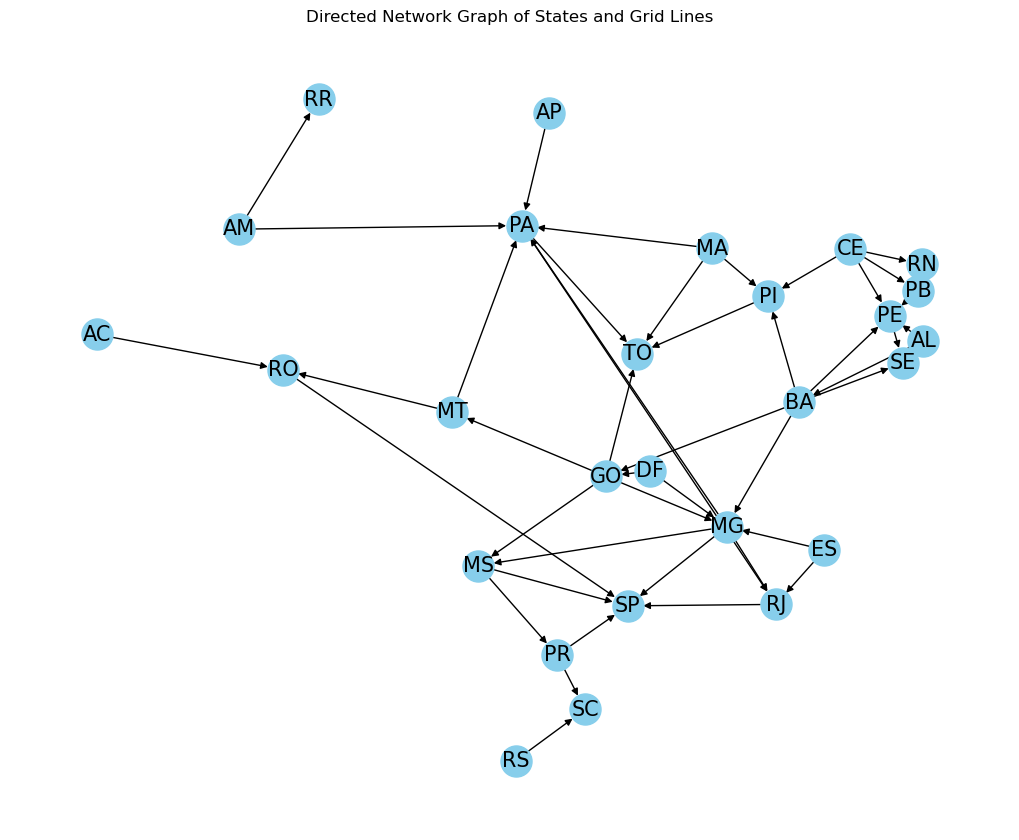

Original Edge List:
   Source Target
0     AC     RO
1     AL     BA
2     AL     PE
3     AL     SE
4     AP     PA
5     AM     PA
6     AM     RR
7     BA     GO
8     BA     MG
9     BA     PE
Generated Edge Index:
 [[ 0 21]
 [ 1  4]
 [ 1 16]
 [ 1 25]
 [ 2 13]
 [ 3 13]
 [ 3 22]
 [ 4  8]
 [ 4 12]
 [ 4 16]]


In [19]:
# Create the directed graph
G = nx.DiGraph()

# Add states as nodes with attributes from static_data
for index, row in static_data.iterrows():
    G.add_node(row['state'], **row.to_dict())

# Add time series data to each node
for state, group in dynamic_data.groupby('state'):
    G.nodes[state]['time_series'] = group.to_dict(orient='records')

# Add edges with attributes from grid_df
for index, row in grid_df.iterrows():
    G.add_edge(row['Source'], row['Target'], **row.to_dict())

# Create a mapping from node identifier (state name) to integer index
node_mapping = {node: idx for idx, node in enumerate(G.nodes)}

# Extract node features (static features) from the graph
node_features_list = []
for node, data in G.nodes(data=True):
    features = [data.get(feature) for feature in ['Population', 'x', 'y', 'pv_pot', 'onw_pot', 'ofw_pot', 'total_plant_capacity', 'GDP']]
    node_features_list.append(features)

# Convert node features to DataFrame for normalization
node_features_df = pd.DataFrame(node_features_list, columns=['Population', 'x', 'y', 'pv_pot', 'onw_pot', 'ofw_pot', 'total_plant_capacity', 'GDP'])

# Normalize the node features using standard scaler
scaler = StandardScaler()
normalized_node_features = scaler.fit_transform(node_features_df)

# Convert normalized node features to tensor and move to the device
node_features_tensor = torch.tensor(normalized_node_features, dtype=torch.float)


# Extract edge index and edge attributes from the graph
edge_index_list = []
edge_attr_list = []
for source, target, data in G.edges(data=True):
    edge_index_list.append([node_mapping[source], node_mapping[target]])
    edge_attr = [data.get(attr) for attr in ['capacity', 'line_eff', 'line_len', 'line_carrier']]
    edge_attr_list.append(edge_attr)

# Convert edge index and edge attributes to tensors and move to the device
edge_index_tensor = torch.tensor(edge_index_list, dtype=torch.long).t().contiguous()
edge_attr_tensor = torch.tensor(edge_attr_list, dtype=torch.float)

# Create torch-geometric data object
graph_data = Data(x=node_features_tensor, edge_index=edge_index_tensor, edge_attr=edge_attr_tensor)

# Print to verify the structure
print(graph_data)
print(f"Node features shape: {node_features_tensor.shape}")
print(f"Edge index shape: {edge_index_tensor.shape}")
print(f"Edge attributes shape: {edge_attr_tensor.shape}")

# Verification steps

# Step 1: Visual Inspection
print("Edge Index Sample:\n", edge_index_tensor[:, :10])

# Step 2: Consistency Check
num_nodes = node_features_tensor.size(0)
if torch.max(edge_index_tensor) >= num_nodes:
    print("Error: Edge index contains invalid node indices.")
else:
    print("Edge index node indices are consistent with node features.")

# Step 3: Visualize the Graph using NetworkX
plt.figure(figsize=(10, 8))
pos = {node: (data['x'], data['y']) for node, data in G.nodes(data=True)}
labels = {node: node for node in G.nodes()}
nx.draw(G, pos, with_labels=True, labels=labels, node_color='skyblue', node_size=500, edge_color='k', linewidths=1, font_size=15, arrows=True)
plt.title("Directed Network Graph of States and Grid Lines")
plt.show()

# Step 4: Compare with Original Data
print("Original Edge List:\n", grid_df[['Source', 'Target']].head(10))
print("Generated Edge Index:\n", edge_index_tensor[:, :10].numpy().T)  

In [20]:
# Dynamic Data Preprocessing
dynamic_data['datetime'] = pd.to_datetime(dynamic_data['datetime'])
dynamic_data = dynamic_data.sort_values(by=['state', 'datetime'])
dynamic_data['target_consumption'] = dynamic_data.groupby('state')['value'].shift(-1)
dynamic_data = dynamic_data.dropna(subset=['target_consumption'])

# Split data into train, validation, and test sets
train_data = dynamic_data[dynamic_data['datetime'] < '2020-07-01'].copy()
val_data = dynamic_data[(dynamic_data['datetime'] >= '2020-07-01') & (dynamic_data['datetime'] < '2020-10-01')].copy()
test_data = dynamic_data[dynamic_data['datetime'] >= '2020-10-01'].copy()

# Create a time index for each dataset
for data in [train_data, val_data, test_data]:
    data.loc[:, 'time_index'] = (data['datetime'] - data['datetime'].min()).dt.total_seconds() // 3600
    data.loc[:, 'time_index'] = data['time_index'].astype(int)

# Determine a reasonable sequence length
train_sequence_length = train_data.groupby('state').size().min() - 1
val_sequence_length = val_data.groupby('state').size().min() - 1
test_sequence_length = test_data.groupby('state').size().min() - 1

# Fit a StandardScaler on the training data and transform all data sets
scaler = StandardScaler()
features_to_scale = ['value', 'pv', 'onw', 'ofw', 'TOTAL HOURLY RAIN (mm)(mean)', 'TOTAL HOURLY RAIN (mm)(std)',
                     'ATMOSPHERIC PRESSURE AT STATION LEVEL (mB)(mean)', 'ATMOSPHERIC PRESSURE AT STATION LEVEL (mB)(std)',
                     'GLOBAL RADIATION (KJ/m²)(mean)', 'GLOBAL RADIATION (KJ/m²)(std)', 'AIR TEMPERATURE (°C)(mean)', 
                     'AIR TEMPERATURE (°C)(std)', 'DEW POINT TEMPERATURE (°C)(mean)', 'DEW POINT TEMPERATURE (°C)(std)', 
                     'REL HUMIDITY FOR THE LAST HOUR (%)(mean)', 'REL HUMIDITY FOR THE LAST HOUR (%)(std)', 
                     'WIND DIRECTION (gr)(mean)', 'WIND DIRECTION (gr)(std)', 'WIND MAXIMUM GUST (m/s)(mean)', 
                     'WIND MAXIMUM GUST (m/s)(std)', 'WIND SPEED (m/s)(mean)', 'WIND SPEED (m/s)(std)', 'month', 
                     'day', 'hour', 'season', 'is_holiday', 'target_consumption']

train_data[features_to_scale] = scaler.fit_transform(train_data[features_to_scale])
val_data[features_to_scale] = scaler.transform(val_data[features_to_scale])
test_data[features_to_scale] = scaler.transform(test_data[features_to_scale])

def create_sequences(data, sequence_length):
    sequences = []
    targets = []
    grouped = data.groupby('state')

    for state, group in grouped:
        group = group.sort_values(by='datetime')
        values = group[features_to_scale[:-1]].values  # Exclude target_consumption from features
        target_values = group['target_consumption'].values
        if len(group) >= sequence_length + 1:  # Ensure there's enough data for at least one sequence
            for i in range(len(group) - sequence_length):
                seq = values[i:i + sequence_length]
                tgt = target_values[i + sequence_length]  # Only the next hour's value as the target
                sequences.append(seq)
                targets.append(tgt)
        else:
            logging.warning(f"Not enough data for state {state} to create sequences of length {sequence_length}")

    sequences_tensor = torch.tensor(np.array(sequences), dtype=torch.float)
    targets_tensor = torch.tensor(np.array(targets), dtype=torch.float).unsqueeze(-1)  # Ensure targets have shape (batch_size, 1)

    return sequences_tensor, targets_tensor

# Create sequences and targets for train, validation, and test sets
train_sequences_tensor, train_targets_tensor = create_sequences(train_data, train_sequence_length)
val_sequences_tensor, val_targets_tensor = create_sequences(val_data, val_sequence_length)
test_sequences_tensor, test_targets_tensor = create_sequences(test_data, test_sequence_length)

# Log the shapes of the created tensors
logging.info(f"Train sequences tensor shape: {train_sequences_tensor.shape}")
logging.info(f"Validation sequences tensor shape: {val_sequences_tensor.shape}")
logging.info(f"Test sequences tensor shape: {test_sequences_tensor.shape}")

logging.info(f"Train targets tensor shape: {train_targets_tensor.shape}")
logging.info(f"Validation targets tensor shape: {val_targets_tensor.shape}")
logging.info(f"Test targets tensor shape: {test_targets_tensor.shape}")


INFO:root:Train sequences tensor shape: torch.Size([27, 4367, 27])
INFO:root:Validation sequences tensor shape: torch.Size([27, 2207, 27])
INFO:root:Test sequences tensor shape: torch.Size([27, 2206, 27])
INFO:root:Train targets tensor shape: torch.Size([27, 1])
INFO:root:Validation targets tensor shape: torch.Size([27, 1])
INFO:root:Test targets tensor shape: torch.Size([27, 1])


## LSTM-GAT Model

INFO:root:Epoch 1/100, Train Loss: 1.2501428127288818, Val Loss: 0.21273615956306458
INFO:root:Epoch 2/100, Train Loss: 1.1875948905944824, Val Loss: 0.21265943348407745
INFO:root:Epoch 3/100, Train Loss: 1.182298183441162, Val Loss: 0.21212483942508698
INFO:root:Epoch 4/100, Train Loss: 1.1902509927749634, Val Loss: 0.21054977178573608
INFO:root:Epoch 5/100, Train Loss: 1.2005867958068848, Val Loss: 0.21048378944396973
INFO:root:Epoch 6/100, Train Loss: 1.186819076538086, Val Loss: 0.21073009073734283
INFO:root:Epoch 7/100, Train Loss: 1.167364239692688, Val Loss: 0.2097870409488678
INFO:root:Epoch 8/100, Train Loss: 1.1452869176864624, Val Loss: 0.20914912223815918
INFO:root:Epoch 9/100, Train Loss: 1.0524779558181763, Val Loss: 0.2064506858587265
INFO:root:Epoch 10/100, Train Loss: 1.0970128774642944, Val Loss: 0.20518778264522552
INFO:root:Epoch 11/100, Train Loss: 1.0787626504898071, Val Loss: 0.20441295206546783
INFO:root:Epoch 12/100, Train Loss: 0.9714926481246948, Val Loss: 0.

Best Score: 0.0025796075933612883
Best Parameters: {'weight_decay': 0.0001, 'num_heads': 16, 'lstm_num_layers': 1, 'lstm_hidden_dim': 256, 'lstm_dropout': 0.1, 'learning_rate': 0.0005, 'gat_hidden_dim': 128, 'gat_dropout': 0.1, 'combined_dim': 128}


INFO:root:Epoch 1/100, Train Loss: 0.764237105846405, Val Loss: 1.3015921115875244
INFO:root:Epoch 2/100, Train Loss: 0.47665053606033325, Val Loss: 1.2948862314224243
INFO:root:Epoch 3/100, Train Loss: 0.27276065945625305, Val Loss: 1.285361409187317
INFO:root:Epoch 4/100, Train Loss: 0.15158914029598236, Val Loss: 1.2725001573562622
INFO:root:Epoch 5/100, Train Loss: 0.1413181871175766, Val Loss: 1.2571420669555664
INFO:root:Epoch 6/100, Train Loss: 0.21228311955928802, Val Loss: 1.2423819303512573
INFO:root:Epoch 7/100, Train Loss: 0.3023011088371277, Val Loss: 1.229813575744629
INFO:root:Epoch 8/100, Train Loss: 0.33643659949302673, Val Loss: 1.2208800315856934
INFO:root:Epoch 9/100, Train Loss: 0.278263121843338, Val Loss: 1.217869758605957
INFO:root:Epoch 10/100, Train Loss: 0.1689596027135849, Val Loss: 1.2201802730560303
INFO:root:Epoch 11/100, Train Loss: 0.09201625734567642, Val Loss: 1.2239415645599365
INFO:root:Epoch 12/100, Train Loss: 0.11089079827070236, Val Loss: 1.2202

Test Metrics: (0.027540989220142365, 0.1659547806486525, 0.12347143888473511, 40.471863746643066, 0.9693317985256257)
Shape of test_predictions: (27, 27, 1)
Shape of test_targets: (27, 27, 1)


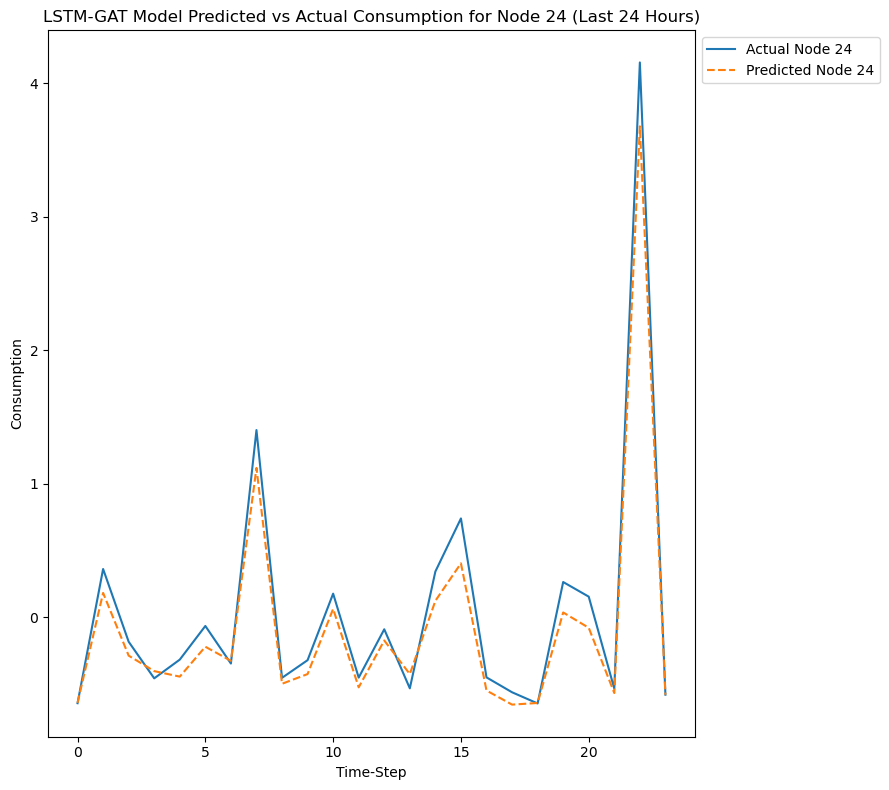

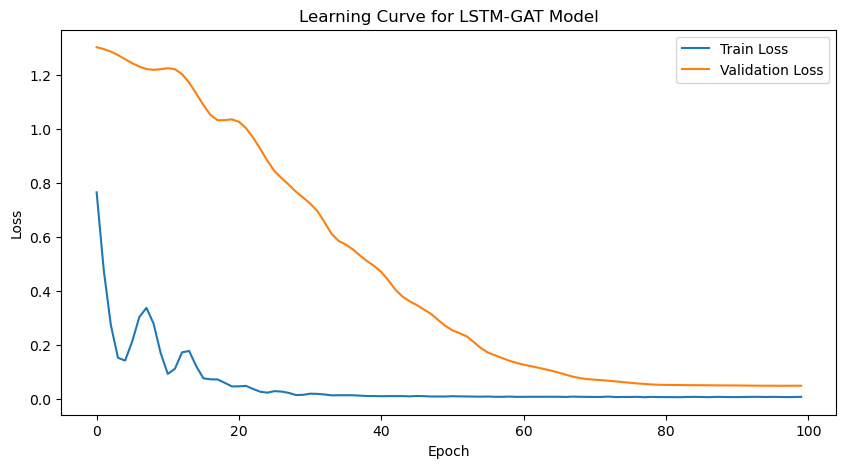

In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.nn as pyg_nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import logging
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold, ParameterSampler
from torch.optim.lr_scheduler import OneCycleLR

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the model
class LSTM_GAT_Model(nn.Module):
    def __init__(self, static_input_dim, lstm_input_dim, lstm_hidden_dim, lstm_num_layers, gat_input_dim, gat_hidden_dim, num_heads, combined_dim, output_dim, lstm_dropout=0.3, gat_dropout=0.3):
        super(LSTM_GAT_Model, self).__init__()

        # LSTM for time series features
        self.lstm = nn.LSTM(lstm_input_dim, lstm_hidden_dim, lstm_num_layers, batch_first=True, dropout=lstm_dropout if lstm_num_layers > 1 else 0.0)
        self.lstm_bn = nn.BatchNorm1d(lstm_hidden_dim)

        # Fully connected layer to combine LSTM output with static features
        self.fc1 = nn.Linear(lstm_hidden_dim + static_input_dim, gat_input_dim)
        self.fc1_bn = nn.BatchNorm1d(gat_input_dim)
        self.dropout1 = nn.Dropout(lstm_dropout)

        # GAT for combined features
        self.gat = pyg_nn.GATConv(gat_input_dim, gat_hidden_dim, heads=num_heads)
        self.gat_bn = nn.BatchNorm1d(gat_hidden_dim * num_heads)
        self.dropout2 = nn.Dropout(gat_dropout)

        # Fully connected layer for final output
        self.fc2 = nn.Linear(gat_hidden_dim * num_heads, combined_dim)
        self.fc2_bn = nn.BatchNorm1d(combined_dim)
        self.fc3 = nn.Linear(combined_dim, output_dim)

    def forward(self, data, sequences):
        sequences = sequences.to(device)
        data = data.to(device)

        # LSTM forward pass
        lstm_out, _ = self.lstm(sequences)
        lstm_out = lstm_out[:, -1, :]  # Use the last hidden state from LSTM
        lstm_out = self.lstm_bn(lstm_out)

        # Ensure data.x has the correct shape and expand it to match the batch size
        static_features = data.x.unsqueeze(0).expand(sequences.size(0), -1, -1)  # (batch_size, num_nodes, static_input_dim)

        # Combine LSTM output with static features
        combined_features = torch.cat([lstm_out.unsqueeze(1).expand(-1, static_features.size(1), -1), static_features], dim=2)  # Concatenate along the feature dimension

        # Fully connected layer to reduce dimension
        combined_features = combined_features.view(-1, combined_features.size(2))  # Flatten batch and num_nodes dimensions
        combined_features = self.fc1(combined_features)
        combined_features = self.fc1_bn(combined_features)
        combined_features = self.dropout1(combined_features)

        # GAT forward pass
        gat_out = self.gat(combined_features, data.edge_index, data.edge_attr)
        gat_out = self.gat_bn(gat_out)
        gat_out = self.dropout2(gat_out)

        # Fully connected layers for final output
        combined_gat = self.fc2(gat_out)
        combined_gat = self.fc2_bn(combined_gat)
        output = self.fc3(combined_gat)

        output = output.view(sequences.size(0), -1, self.fc3.out_features)  # Reshape to (batch_size, num_nodes, output_dim)
        return output  # Return node-specific outputs

# Compute metrics
def compute_metrics(output, target, criterion):
    mse = criterion(output, target).item()
    rmse = np.sqrt(mse)
    mae = torch.mean(torch.abs(output - target)).item()
    mape = torch.mean(torch.abs((output - target) / (target + 1e-5))).item() * 100
    return mse, rmse, mae, mape

# Hyperparameter space for random search
param_distributions = {
    'lstm_hidden_dim': [64, 128, 256],
    'lstm_num_layers': [1, 2, 3],
    'gat_hidden_dim': [32, 64, 128],
    'num_heads': [4, 8, 16],
    'combined_dim': [64, 128, 256],
    'lstm_dropout': [0.1, 0.2, 0.3],
    'gat_dropout': [0.1, 0.2, 0.3],
    'learning_rate': [0.001, 0.0005, 0.0001],
    'weight_decay': [1e-4, 5e-4, 1e-3]
}

# K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Define test_loader outside the function
test_loader = DataLoader(TensorDataset(test_sequences_tensor, test_targets_tensor), batch_size=48, shuffle=False)

# Training and evaluation function with cross-validation
def cross_val_evaluate(param_sample, graph_data):
    lstm_hidden_dim = param_sample['lstm_hidden_dim']
    lstm_num_layers = param_sample['lstm_num_layers']
    gat_hidden_dim = param_sample['gat_hidden_dim']
    num_heads = param_sample['num_heads']
    combined_dim = param_sample['combined_dim']
    lstm_dropout = param_sample['lstm_dropout']
    gat_dropout = param_sample['gat_dropout']
    learning_rate = param_sample['learning_rate']
    weight_decay = param_sample['weight_decay']

    model = LSTM_GAT_Model(
        static_input_dim=8,
        lstm_input_dim=27,
        lstm_hidden_dim=lstm_hidden_dim,
        lstm_num_layers=lstm_num_layers,
        gat_input_dim=lstm_hidden_dim + 8,  # Corrected static_input_dim here
        gat_hidden_dim=gat_hidden_dim,
        num_heads=num_heads,
        combined_dim=combined_dim,
        output_dim=1,
        lstm_dropout=lstm_dropout,
        gat_dropout=gat_dropout
    ).to(device)  # Move model to device

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    num_epochs = 100
    batch_size = 48
    early_stopping_patience = 20
    best_val_loss = float('inf')
    epochs_no_improve = 0

    aggregated_metrics = {'mse': [], 'rmse': [], 'mae': [], 'mape': [], 'r2': []}

    for train_index, val_index in kf.split(train_sequences_tensor):
        train_sequences, val_sequences = train_sequences_tensor[train_index].to(device), train_sequences_tensor[val_index].to(device)
        train_targets, val_targets = train_targets_tensor[train_index].to(device), train_targets_tensor[val_index].to(device)

        train_loader = DataLoader(TensorDataset(train_sequences, train_targets), batch_size=batch_size, shuffle=False)
        val_loader = DataLoader(TensorDataset(val_sequences, val_targets), batch_size=batch_size, shuffle=False)

        # Initialize the scheduler here, after train_loader is defined
        scheduler = OneCycleLR(optimizer, max_lr=learning_rate, epochs=num_epochs, steps_per_epoch=len(train_loader))

        # Lists to store losses
        train_losses = []
        val_losses = []

        # Training loop
        for epoch in range(num_epochs):
            model.train()
            train_loss = 0
            for sequences, targets in train_loader:
                sequences, targets = sequences.to(device), targets.to(device)
                optimizer.zero_grad()
                output = model(graph_data, sequences)

                # Ensure the target shape matches the output shape
                targets_expanded = targets.unsqueeze(1).expand(-1, output.size(1), -1)  # Shape should be (batch_size, num_nodes, 1)

                loss = criterion(output, targets_expanded)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()

            # Validation
            model.eval()
            val_loss = 0
            with torch.no_grad():
                for sequences, targets in val_loader:
                    sequences, targets = sequences.to(device), targets.to(device)
                    output = model(graph_data, sequences)

                    # Ensure the target shape matches the output shape
                    targets_expanded = targets.unsqueeze(1).expand(-1, output.size(1), -1)  # Shape should be (batch_size, num_nodes, 1)

                    loss = criterion(output, targets_expanded)
                    val_loss += loss.item()

            train_loss /= len(train_loader)
            val_loss /= len(val_loader)
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            logging.info(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss}, Val Loss: {val_loss}')

            # Learning rate scheduling
            scheduler.step()

            # Early stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                epochs_no_improve = 0
                torch.save(model.state_dict(), 'best_model.pth')
            else:
                epochs_no_improve += 1
                if epochs_no_improve >= early_stopping_patience:
                    logging.info('Early stopping triggered')
                    break

        # Load the best model
        model.load_state_dict(torch.load('best_model.pth'))

        # Validation evaluation
        model.eval()
        val_mse, val_rmse, val_mae, val_mape = 0, 0, 0, 0
        all_predictions = []
        all_targets = []
        with torch.no_grad():
            for sequences, targets in val_loader:
                sequences, targets = sequences.to(device), targets.to(device)
                output = model(graph_data, sequences)

                # Ensure the target shape matches the output shape
                targets_expanded = targets.unsqueeze(1).expand(-1, output.size(1), -1)  # Shape should be (batch_size, num_nodes, 1)

                mse, rmse, mae, mape = compute_metrics(output, targets_expanded, criterion)
                val_mse += mse
                val_rmse += rmse
                val_mae += mae
                val_mape += mape

                all_predictions.append(output.cpu().numpy())
                all_targets.append(targets_expanded.cpu().numpy())

        # Compute overall R-squared
        all_predictions = np.vstack(all_predictions)
        all_targets = np.vstack(all_targets)

        # Flatten the arrays to 2D for r2_score computation
        all_predictions_flat = all_predictions.reshape(-1, 1)
        all_targets_flat = all_targets.reshape(-1, 1)

        val_r2 = r2_score(all_targets_flat, all_predictions_flat)

        val_mse /= len(val_loader)
        val_rmse /= len(val_loader)
        val_mae /= len(val_loader)
        val_mape /= len(val_loader)

        aggregated_metrics['mse'].append(val_mse)
        aggregated_metrics['rmse'].append(val_rmse)
        aggregated_metrics['mae'].append(val_mae)
        aggregated_metrics['mape'].append(val_mape)
        aggregated_metrics['r2'].append(val_r2)

    avg_metrics = {metric: np.mean(aggregated_metrics[metric]) for metric in aggregated_metrics}
    logging.info(f'Avg Validation Metrics: {avg_metrics}')

    return avg_metrics

# Random search for hyperparameter tuning
param_samples = list(ParameterSampler(param_distributions, n_iter=20, random_state=42))
best_score = float('inf')
best_params = None

for param_sample in param_samples:
    avg_metrics = cross_val_evaluate(param_sample, graph_data)
    if avg_metrics['mse'] < best_score:
        best_score = avg_metrics['mse']
        best_params = param_sample

print(f'Best Score: {best_score}')
print(f'Best Parameters: {best_params}')

# Train on the full training set with the best hyperparameters
def train_on_full_train_set(best_params, graph_data):
    lstm_hidden_dim = best_params['lstm_hidden_dim']
    lstm_num_layers = best_params['lstm_num_layers']
    gat_hidden_dim = best_params['gat_hidden_dim']
    num_heads = best_params['num_heads']
    combined_dim = best_params['combined_dim']
    lstm_dropout = best_params['lstm_dropout']
    gat_dropout = best_params['gat_dropout']
    learning_rate = best_params['learning_rate']
    weight_decay = best_params['weight_decay']
    num_epochs = 100  # Define num_epochs
    batch_size = 48  # Define batch_size

    model = LSTM_GAT_Model(
        static_input_dim=8,
        lstm_input_dim=27,
        lstm_hidden_dim=lstm_hidden_dim,
        lstm_num_layers=lstm_num_layers,
        gat_input_dim=lstm_hidden_dim + 8,  # Corrected static_input_dim here
        gat_hidden_dim=gat_hidden_dim,
        num_heads=num_heads,
        combined_dim=combined_dim,
        output_dim=1,
        lstm_dropout=lstm_dropout,
        gat_dropout=gat_dropout
    ).to(device)  # Move model to device

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    train_loader = DataLoader(TensorDataset(train_sequences_tensor, train_targets_tensor), batch_size=batch_size, shuffle=False)

    # Initialize the scheduler here, after train_loader is defined
    scheduler = OneCycleLR(optimizer, max_lr=learning_rate, epochs=num_epochs, steps_per_epoch=len(train_loader))

    early_stopping_patience = 20
    best_val_loss = float('inf')
    epochs_no_improve = 0

    val_loader = DataLoader(TensorDataset(val_sequences_tensor, val_targets_tensor), batch_size=batch_size, shuffle=False)

    # Lists to store losses
    train_losses = []
    val_losses = []

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for sequences, targets in train_loader:
            sequences, targets = sequences.to(device), targets.to(device)
            optimizer.zero_grad()
            output = model(graph_data, sequences)

            # Ensure the target shape matches the output shape
            targets_expanded = targets.unsqueeze(1).expand(-1, output.size(1), -1)  # Shape should be (batch_size, num_nodes, 1)

            loss = criterion(output, targets_expanded)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for sequences, targets in val_loader:
                sequences, targets = sequences.to(device), targets.to(device)
                output = model(graph_data, sequences)

                # Ensure the target shape matches the output shape
                targets_expanded = targets.unsqueeze(1).expand(-1, output.size(1), -1)  # Shape should be (batch_size, num_nodes, 1)

                loss = criterion(output, targets_expanded)
                val_loss += loss.item()

        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        logging.info(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss}, Val Loss: {val_loss}')

        # Learning rate scheduling
        scheduler.step()

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), 'best_model_full_train.pth')
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= early_stopping_patience:
                logging.info('Early stopping triggered')
                break

    # Load the best model
    model.load_state_dict(torch.load('best_model_full_train.pth'))

    return model, train_losses, val_losses

best_model, best_train_losses, best_val_losses = train_on_full_train_set(best_params, graph_data)

# Test evaluation
def evaluate_on_test_set(model, graph_data, criterion):
    model.eval()
    test_mse, test_rmse, test_mae, test_mape = 0, 0, 0, 0
    all_predictions = []
    all_targets = []
    with torch.no_grad():
        for sequences, targets in test_loader:
            sequences, targets = sequences.to(device), targets.to(device)
            output = model(graph_data, sequences)

            # Ensure the target shape matches the output shape
            targets_expanded = targets.unsqueeze(1).expand(-1, output.size(1), -1)  # Shape should be (batch_size, num_nodes, 1)

            mse, rmse, mae, mape = compute_metrics(output, targets_expanded, criterion)
            test_mse += mse
            test_rmse += rmse
            test_mae += mae
            test_mape += mape

            all_predictions.append(output.cpu().numpy())
            all_targets.append(targets_expanded.cpu().numpy())

    # Compute overall R-squared
    all_predictions = np.vstack(all_predictions)
    all_targets = np.vstack(all_targets)

    # Flatten the arrays to 2D for r2_score computation
    all_predictions_flat = all_predictions.reshape(-1, 1)
    all_targets_flat = all_targets.reshape(-1, 1)

    test_r2 = r2_score(all_targets_flat, all_predictions_flat)

    test_mse /= len(test_loader)
    test_rmse /= len(test_loader)
    test_mae /= len(test_loader)
    test_mape /= len(test_loader)

    logging.info(f'Test MSE: {test_mse}, Test RMSE: {test_rmse}, Test MAE: {test_mae}, Test MAPE: {test_mape}, Test R2: {test_r2}')

    return (test_mse, test_rmse, test_mae, test_mape, test_r2), all_predictions, all_targets

# Pass criterion as an argument
test_metrics, test_predictions, test_targets = evaluate_on_test_set(best_model, graph_data, nn.MSELoss())

# Debugging prints
print(f'Test Metrics: {test_metrics}')
print("Shape of test_predictions:", test_predictions.shape)
print("Shape of test_targets:", test_targets.shape)

# Plotting the predictions vs. actual values for the last 24 hours
last_hours = 24

if test_predictions.shape[0] >= last_hours and test_targets.shape[0] >= last_hours:
    last_predictions = test_predictions[-last_hours:, :]
    last_targets = test_targets[-last_hours:, :]
    node_index = 24

    plt.figure(figsize=(12, 8))
    plt.plot(last_targets[:, node_index], label=f'Actual Node {node_index}')
    plt.plot(last_predictions[:, node_index], label=f'Predicted Node {node_index}', linestyle='dashed')

    plt.xlabel('Time-Step')
    plt.ylabel('Consumption')
    plt.title(f'LSTM-GAT Model Predicted vs Actual Consumption for Node {node_index} (Last {last_hours} Hours)')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=1)
    plt.tight_layout(rect=[0, 0, 0.75, 1])
    plt.show()
else:
    print(f"Not enough samples to plot the last {last_hours} hours.")

# Plotting the learning curves
plt.figure(figsize=(10, 5))
plt.plot(best_train_losses, label='Train Loss')
plt.plot(best_val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve for LSTM-GAT Model')
plt.legend()
plt.show()


Shape of test_predictions: (27, 27, 1)
Shape of test_targets: (27, 27, 1)


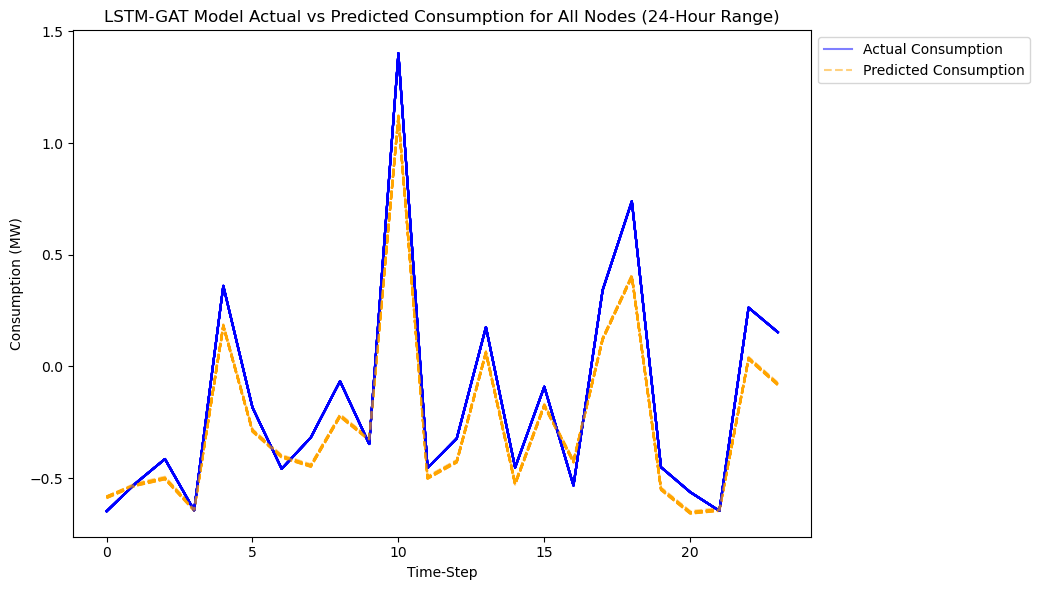

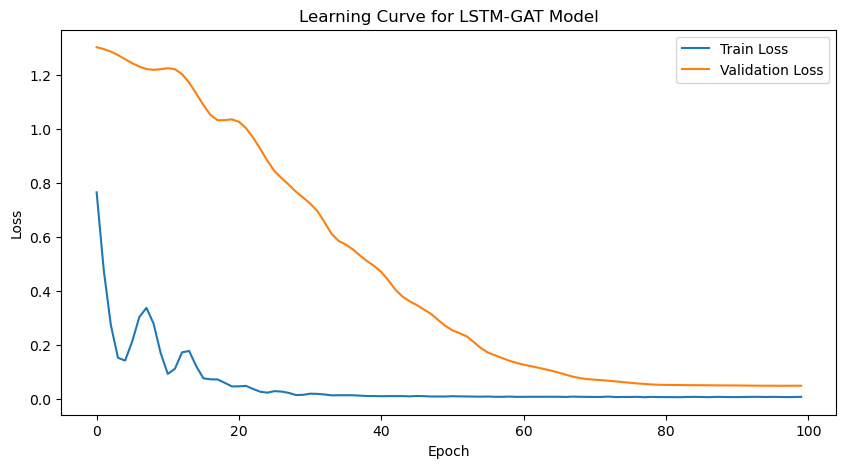

In [28]:
# Debugging prints
print("Shape of test_predictions:", test_predictions.shape)
print("Shape of test_targets:", test_targets.shape)

# Plotting the predictions vs. actual values for a specific 24-hour range for all nodes
range_hours = 24

# Ensure there are enough samples for the specified range
if test_predictions.shape[0] >= range_hours and test_targets.shape[0] >= range_hours:
    # Select any 24-hour range
    range_start = 0  # Change this to specify different starting points
    range_end = range_start + range_hours

    selected_predictions = test_predictions[range_start:range_end, :]
    selected_targets = test_targets[range_start:range_end, :]

    # Plotting
    fig, ax = plt.subplots(figsize=(14, 6))

    for node_index in range(selected_predictions.shape[1]):
        ax.plot(selected_targets[:, node_index], label='Actual Consumption' if node_index == 0 else "", color='blue', alpha=0.5)
        ax.plot(selected_predictions[:, node_index], label='Predicted Consumption' if node_index == 0 else "", linestyle='dashed', color='orange', alpha=0.5)
    
    ax.set_title(f'LSTM-GAT Model Actual vs Predicted Consumption for All Nodes ({range_hours}-Hour Range)')
    ax.set_xlabel('Time-Step')
    ax.set_ylabel('Consumption (MW)')
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=1)

    plt.tight_layout(rect=[0, 0, 0.75, 1])
    plt.show()
else:
    print(f"Not enough samples to plot the {range_hours}-hour range.")

# Plotting the learning curves
plt.figure(figsize=(10, 5))
plt.plot(best_train_losses, label='Train Loss')
plt.plot(best_val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve for LSTM-GAT Model')
plt.legend()
plt.show()


In [ ]:
xxcscdmndmdmd

## LSTM-GAT-skip con + LSTM_attn

INFO:root:Epoch 1/100, Train Loss: 0.704412579536438, Val Loss: 0.25709661841392517
INFO:root:Epoch 2/100, Train Loss: 0.6328338980674744, Val Loss: 0.25656142830848694
INFO:root:Epoch 3/100, Train Loss: 0.6099414825439453, Val Loss: 0.25584787130355835
INFO:root:Epoch 4/100, Train Loss: 0.6514821648597717, Val Loss: 0.2550116181373596
INFO:root:Epoch 5/100, Train Loss: 0.6467693448066711, Val Loss: 0.25349828600883484
INFO:root:Epoch 6/100, Train Loss: 0.6496853232383728, Val Loss: 0.2529843747615814
INFO:root:Epoch 7/100, Train Loss: 0.6342416405677795, Val Loss: 0.250681072473526
INFO:root:Epoch 8/100, Train Loss: 0.6277428269386292, Val Loss: 0.2474360316991806
INFO:root:Epoch 9/100, Train Loss: 0.6362631916999817, Val Loss: 0.2451857179403305
INFO:root:Epoch 10/100, Train Loss: 0.5881099104881287, Val Loss: 0.24210837483406067
INFO:root:Epoch 11/100, Train Loss: 0.4949337840080261, Val Loss: 0.23831376433372498
INFO:root:Epoch 12/100, Train Loss: 0.48597708344459534, Val Loss: 0.2

Best Score: 0.0023714064038358627
Best Parameters: {'weight_decay': 0.0001, 'num_heads': 16, 'lstm_num_layers': 1, 'lstm_hidden_dim': 256, 'lstm_dropout': 0.1, 'learning_rate': 0.0005, 'gat_hidden_dim': 128, 'gat_dropout': 0.1, 'combined_dim': 128}


INFO:root:Epoch 1/100, Train Loss: 1.3109115362167358, Val Loss: 1.3015830516815186
INFO:root:Epoch 2/100, Train Loss: 0.8422613739967346, Val Loss: 1.294285535812378
INFO:root:Epoch 3/100, Train Loss: 0.5076543688774109, Val Loss: 1.2834768295288086
INFO:root:Epoch 4/100, Train Loss: 0.25940147042274475, Val Loss: 1.2681849002838135
INFO:root:Epoch 5/100, Train Loss: 0.19836381077766418, Val Loss: 1.2475671768188477
INFO:root:Epoch 6/100, Train Loss: 0.25592073798179626, Val Loss: 1.2228093147277832
INFO:root:Epoch 7/100, Train Loss: 0.4115837514400482, Val Loss: 1.198229432106018
INFO:root:Epoch 8/100, Train Loss: 0.4605790674686432, Val Loss: 1.1777737140655518
INFO:root:Epoch 9/100, Train Loss: 0.4938683807849884, Val Loss: 1.1647961139678955
INFO:root:Epoch 10/100, Train Loss: 0.4068116247653961, Val Loss: 1.161933183670044
INFO:root:Epoch 11/100, Train Loss: 0.29245707392692566, Val Loss: 1.1677112579345703
INFO:root:Epoch 12/100, Train Loss: 0.1484036147594452, Val Loss: 1.17881

Test Metrics: (0.43960052728652954, 0.6630237758078736, 0.6441996693611145, 217.51699447631836, 0.5104838913585039)
Shape of test_predictions: (27, 27, 1)
Shape of test_targets: (27, 27, 1)


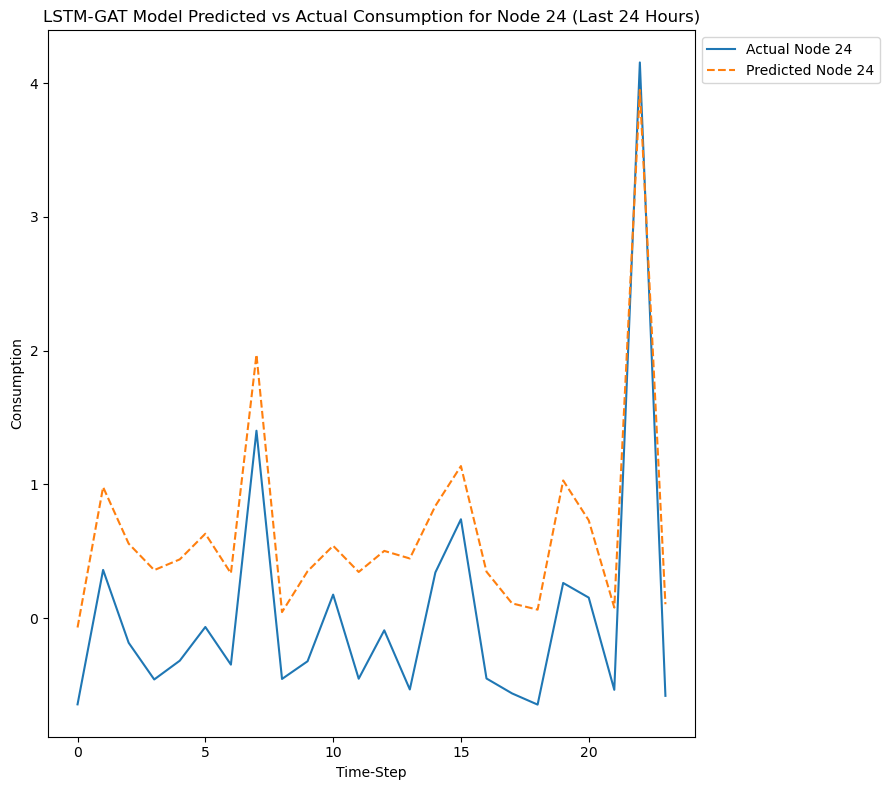

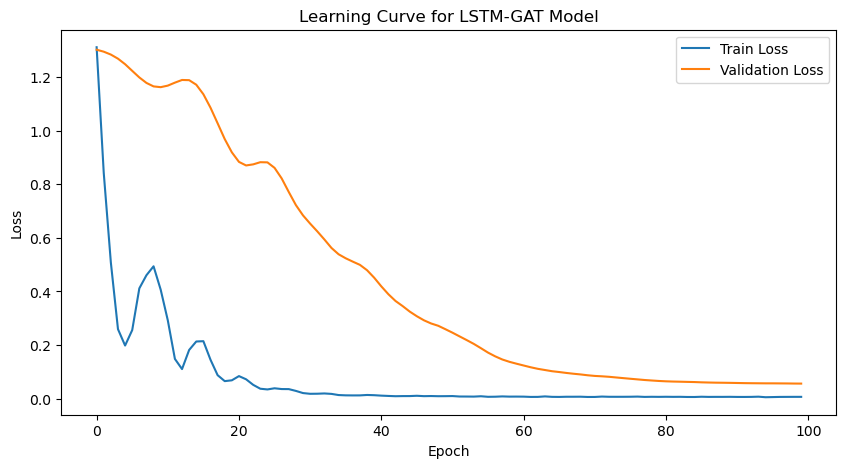

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.nn as pyg_nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import logging
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold, ParameterSampler
from torch.optim.lr_scheduler import OneCycleLR

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the model
class LSTM_GAT_Model(nn.Module):
    def __init__(self, static_input_dim, lstm_input_dim, lstm_hidden_dim, lstm_num_layers, gat_input_dim, gat_hidden_dim, num_heads, combined_dim, output_dim, lstm_dropout=0.3, gat_dropout=0.3):
        super(LSTM_GAT_Model, self).__init__()

        # LSTM for time series features
        self.lstm = nn.LSTM(lstm_input_dim, lstm_hidden_dim, lstm_num_layers, batch_first=True, dropout=lstm_dropout if lstm_num_layers > 1 else 0.0)
        self.lstm_bn = nn.BatchNorm1d(lstm_hidden_dim)

        # Attention mechanism
        self.attention = nn.Linear(lstm_hidden_dim, 1)

        # Fully connected layer to combine LSTM output with static features
        self.fc1 = nn.Linear(lstm_hidden_dim + static_input_dim, gat_input_dim)
        self.fc1_bn = nn.BatchNorm1d(gat_input_dim)
        self.dropout1 = nn.Dropout(lstm_dropout)

        # GAT for combined features
        self.gat = pyg_nn.GATConv(gat_input_dim, gat_hidden_dim, heads=num_heads)
        self.gat_bn = nn.BatchNorm1d(gat_hidden_dim * num_heads)
        self.dropout2 = nn.Dropout(gat_dropout)

        # Fully connected layer for final output
        self.fc2 = nn.Linear(gat_hidden_dim * num_heads + gat_input_dim, combined_dim)  # Adjusted for skip connection
        self.fc2_bn = nn.BatchNorm1d(combined_dim)
        self.fc3 = nn.Linear(combined_dim, output_dim)

    def forward(self, data, sequences):
        sequences = sequences.to(device)
        data = data.to(device)

        # LSTM forward pass
        lstm_out, _ = self.lstm(sequences)
        lstm_out = lstm_out[:, -1, :]  # Use the last hidden state from LSTM
        lstm_out = self.lstm_bn(lstm_out)

        # Attention mechanism
        attn_weights = F.softmax(self.attention(lstm_out), dim=1)
        attn_out = torch.sum(lstm_out.unsqueeze(1) * attn_weights.unsqueeze(2), dim=1)  # Weighted sum of LSTM outputs

        # Ensure data.x has the correct shape and expand it to match the batch size
        static_features = data.x.unsqueeze(0).expand(sequences.size(0), -1, -1)  # (batch_size, num_nodes, static_input_dim)

        # Combine LSTM output with static features
        attn_out_expanded = attn_out.unsqueeze(1).expand(-1, static_features.size(1), -1)  # (batch_size, num_nodes, lstm_hidden_dim)
        combined_features = torch.cat([attn_out_expanded, static_features], dim=2)  # Concatenate along the feature dimension

        # Fully connected layer to reduce dimension
        combined_features = combined_features.view(-1, combined_features.size(2))  # Flatten batch and num_nodes dimensions
        combined_features = self.fc1(combined_features)
        combined_features = self.fc1_bn(combined_features)
        combined_features = self.dropout1(combined_features)

        # GAT forward pass
        gat_out = self.gat(combined_features, data.edge_index, data.edge_attr)
        gat_out = self.gat_bn(gat_out)
        gat_out = self.dropout2(gat_out)

        # Combine GAT outputs with the original combined features (skip connection)
        combined_gat = torch.cat([gat_out, combined_features], dim=1)

        # Fully connected layers for final output
        combined_gat = self.fc2(combined_gat)
        combined_gat = self.fc2_bn(combined_gat)
        output = self.fc3(combined_gat)

        output = output.view(sequences.size(0), -1, self.fc3.out_features)  # Reshape to (batch_size, num_nodes, output_dim)
        return output  # Return node-specific outputs

# Compute metrics
def compute_metrics(output, target, criterion):
    mse = criterion(output, target).item()
    rmse = np.sqrt(mse)
    mae = torch.mean(torch.abs(output - target)).item()
    mape = torch.mean(torch.abs((output - target) / (target + 1e-5))).item() * 100
    return mse, rmse, mae, mape

# Hyperparameter space for random search
param_distributions = {
    'lstm_hidden_dim': [64, 128, 256],
    'lstm_num_layers': [1, 2, 3],
    'gat_hidden_dim': [32, 64, 128],
    'num_heads': [4, 8, 16],
    'combined_dim': [64, 128, 256],
    'lstm_dropout': [0.1, 0.2, 0.3],
    'gat_dropout': [0.1, 0.2, 0.3],
    'learning_rate': [0.001, 0.0005, 0.0001],
    'weight_decay': [1e-4, 5e-4, 1e-3]
}

# K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Define test_loader outside the function
test_loader = DataLoader(TensorDataset(test_sequences_tensor, test_targets_tensor), batch_size=48, shuffle=False)

# Training and evaluation function with cross-validation
def cross_val_evaluate(param_sample, graph_data):
    lstm_hidden_dim = param_sample['lstm_hidden_dim']
    lstm_num_layers = param_sample['lstm_num_layers']
    gat_hidden_dim = param_sample['gat_hidden_dim']
    num_heads = param_sample['num_heads']
    combined_dim = param_sample['combined_dim']
    lstm_dropout = param_sample['lstm_dropout']
    gat_dropout = param_sample['gat_dropout']
    learning_rate = param_sample['learning_rate']
    weight_decay = param_sample['weight_decay']

    model = LSTM_GAT_Model(
        static_input_dim=8,
        lstm_input_dim=27,
        lstm_hidden_dim=lstm_hidden_dim,
        lstm_num_layers=lstm_num_layers,
        gat_input_dim=lstm_hidden_dim + 8,  # Corrected static_input_dim here
        gat_hidden_dim=gat_hidden_dim,
        num_heads=num_heads,
        combined_dim=combined_dim,
        output_dim=1,
        lstm_dropout=lstm_dropout,
        gat_dropout=gat_dropout
    ).to(device)  # Move model to device

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    num_epochs = 100
    batch_size = 48
    early_stopping_patience = 20
    best_val_loss = float('inf')
    epochs_no_improve = 0

    aggregated_metrics = {'mse': [], 'rmse': [], 'mae': [], 'mape': [], 'r2': []}

    for train_index, val_index in kf.split(train_sequences_tensor):
        train_sequences, val_sequences = train_sequences_tensor[train_index].to(device), train_sequences_tensor[val_index].to(device)
        train_targets, val_targets = train_targets_tensor[train_index].to(device), train_targets_tensor[val_index].to(device)

        train_loader = DataLoader(TensorDataset(train_sequences, train_targets), batch_size=batch_size, shuffle=False)
        val_loader = DataLoader(TensorDataset(val_sequences, val_targets), batch_size=batch_size, shuffle=False)

        # Initialize the scheduler here, after train_loader is defined
        scheduler = OneCycleLR(optimizer, max_lr=learning_rate, epochs=num_epochs, steps_per_epoch=len(train_loader))

        # Lists to store losses
        train_losses = []
        val_losses = []

        # Training loop
        for epoch in range(num_epochs):
            model.train()
            train_loss = 0
            for sequences, targets in train_loader:
                sequences, targets = sequences.to(device), targets.to(device)
                optimizer.zero_grad()
                output = model(graph_data, sequences)

                # Ensure the target shape matches the output shape
                targets_expanded = targets.unsqueeze(1).expand(-1, output.size(1), -1)  # Shape should be (batch_size, num_nodes, 1)

                loss = criterion(output, targets_expanded)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()

            # Validation
            model.eval()
            val_loss = 0
            with torch.no_grad():
                for sequences, targets in val_loader:
                    sequences, targets = sequences.to(device), targets.to(device)
                    output = model(graph_data, sequences)

                    # Ensure the target shape matches the output shape
                    targets_expanded = targets.unsqueeze(1).expand(-1, output.size(1), -1)  # Shape should be (batch_size, num_nodes, 1)

                    loss = criterion(output, targets_expanded)
                    val_loss += loss.item()

            train_loss /= len(train_loader)
            val_loss /= len(val_loader)
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            logging.info(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss}, Val Loss: {val_loss}')

            # Learning rate scheduling
            scheduler.step()

            # Early stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                epochs_no_improve = 0
                torch.save(model.state_dict(), 'best_model.pth')
            else:
                epochs_no_improve += 1
                if epochs_no_improve >= early_stopping_patience:
                    logging.info('Early stopping triggered')
                    break

        # Load the best model
        model.load_state_dict(torch.load('best_model.pth'))

        # Validation evaluation
        model.eval()
        val_mse, val_rmse, val_mae, val_mape = 0, 0, 0, 0
        all_predictions = []
        all_targets = []
        with torch.no_grad():
            for sequences, targets in val_loader:
                sequences, targets = sequences.to(device), targets.to(device)
                output = model(graph_data, sequences)

                # Ensure the target shape matches the output shape
                targets_expanded = targets.unsqueeze(1).expand(-1, output.size(1), -1)  # Shape should be (batch_size, num_nodes, 1)

                mse, rmse, mae, mape = compute_metrics(output, targets_expanded, criterion)
                val_mse += mse
                val_rmse += rmse
                val_mae += mae
                val_mape += mape

                all_predictions.append(output.cpu().numpy())
                all_targets.append(targets_expanded.cpu().numpy())

        # Compute overall R-squared
        all_predictions = np.vstack(all_predictions)
        all_targets = np.vstack(all_targets)

        # Flatten the arrays to 2D for r2_score computation
        all_predictions_flat = all_predictions.reshape(-1, 1)
        all_targets_flat = all_targets.reshape(-1, 1)

        val_r2 = r2_score(all_targets_flat, all_predictions_flat)

        val_mse /= len(val_loader)
        val_rmse /= len(val_loader)
        val_mae /= len(val_loader)
        val_mape /= len(val_loader)

        aggregated_metrics['mse'].append(val_mse)
        aggregated_metrics['rmse'].append(val_rmse)
        aggregated_metrics['mae'].append(val_mae)
        aggregated_metrics['mape'].append(val_mape)
        aggregated_metrics['r2'].append(val_r2)

    avg_metrics = {metric: np.mean(aggregated_metrics[metric]) for metric in aggregated_metrics}
    logging.info(f'Avg Validation Metrics: {avg_metrics}')

    return avg_metrics

# Random search for hyperparameter tuning
param_samples = list(ParameterSampler(param_distributions, n_iter=20, random_state=42))
best_score = float('inf')
best_params = None

for param_sample in param_samples:
    avg_metrics = cross_val_evaluate(param_sample, graph_data)
    if avg_metrics['mse'] < best_score:
        best_score = avg_metrics['mse']
        best_params = param_sample

print(f'Best Score: {best_score}')
print(f'Best Parameters: {best_params}')

# Train on the full training set with the best hyperparameters
def train_on_full_train_set(best_params, graph_data):
    lstm_hidden_dim = best_params['lstm_hidden_dim']
    lstm_num_layers = best_params['lstm_num_layers']
    gat_hidden_dim = best_params['gat_hidden_dim']
    num_heads = best_params['num_heads']
    combined_dim = best_params['combined_dim']
    lstm_dropout = best_params['lstm_dropout']
    gat_dropout = best_params['gat_dropout']
    learning_rate = best_params['learning_rate']
    weight_decay = best_params['weight_decay']
    num_epochs = 100  # Define num_epochs
    batch_size = 48  # Define batch_size

    model = LSTM_GAT_Model(
        static_input_dim=8,
        lstm_input_dim=27,
        lstm_hidden_dim=lstm_hidden_dim,
        lstm_num_layers=lstm_num_layers,
        gat_input_dim=lstm_hidden_dim + 8,  # Corrected static_input_dim here
        gat_hidden_dim=gat_hidden_dim,
        num_heads=num_heads,
        combined_dim=combined_dim,
        output_dim=1,
        lstm_dropout=lstm_dropout,
        gat_dropout=gat_dropout
    ).to(device)  # Move model to device

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    train_loader = DataLoader(TensorDataset(train_sequences_tensor, train_targets_tensor), batch_size=batch_size, shuffle=False)

    # Initialize the scheduler here, after train_loader is defined
    scheduler = OneCycleLR(optimizer, max_lr=learning_rate, epochs=num_epochs, steps_per_epoch=len(train_loader))

    early_stopping_patience = 20
    best_val_loss = float('inf')
    epochs_no_improve = 0

    val_loader = DataLoader(TensorDataset(val_sequences_tensor, val_targets_tensor), batch_size=batch_size, shuffle=False)

    # Lists to store losses
    train_losses = []
    val_losses = []

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for sequences, targets in train_loader:
            sequences, targets = sequences.to(device), targets.to(device)
            optimizer.zero_grad()
            output = model(graph_data, sequences)

            # Ensure the target shape matches the output shape
            targets_expanded = targets.unsqueeze(1).expand(-1, output.size(1), -1)  # Shape should be (batch_size, num_nodes, 1)

            loss = criterion(output, targets_expanded)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for sequences, targets in val_loader:
                sequences, targets = sequences.to(device), targets.to(device)
                output = model(graph_data, sequences)

                # Ensure the target shape matches the output shape
                targets_expanded = targets.unsqueeze(1).expand(-1, output.size(1), -1)  # Shape should be (batch_size, num_nodes, 1)

                loss = criterion(output, targets_expanded)
                val_loss += loss.item()

        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        logging.info(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss}, Val Loss: {val_loss}')

        # Learning rate scheduling
        scheduler.step()

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), 'best_model_full_train.pth')
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= early_stopping_patience:
                logging.info('Early stopping triggered')
                break

    # Load the best model
    model.load_state_dict(torch.load('best_model_full_train.pth'))

    return model, train_losses, val_losses

best_model, best_train_losses, best_val_losses = train_on_full_train_set(best_params, graph_data)

# Test evaluation
def evaluate_on_test_set(model, graph_data, criterion):
    model.eval()
    test_mse, test_rmse, test_mae, test_mape = 0, 0, 0, 0
    all_predictions = []
    all_targets = []
    with torch.no_grad():
        for sequences, targets in test_loader:
            sequences, targets = sequences.to(device), targets.to(device)
            output = model(graph_data, sequences)

            # Ensure the target shape matches the output shape
            targets_expanded = targets.unsqueeze(1).expand(-1, output.size(1), -1)  # Shape should be (batch_size, num_nodes, 1)

            mse, rmse, mae, mape = compute_metrics(output, targets_expanded, criterion)
            test_mse += mse
            test_rmse += rmse
            test_mae += mae
            test_mape += mape

            all_predictions.append(output.cpu().numpy())
            all_targets.append(targets_expanded.cpu().numpy())

    # Compute overall R-squared
    all_predictions = np.vstack(all_predictions)
    all_targets = np.vstack(all_targets)

    # Flatten the arrays to 2D for r2_score computation
    all_predictions_flat = all_predictions.reshape(-1, 1)
    all_targets_flat = all_targets.reshape(-1, 1)

    test_r2 = r2_score(all_targets_flat, all_predictions_flat)

    test_mse /= len(test_loader)
    test_rmse /= len(test_loader)
    test_mae /= len(test_loader)
    test_mape /= len(test_loader)

    logging.info(f'Test MSE: {test_mse}, Test RMSE: {test_rmse}, Test MAE: {test_mae}, Test MAPE: {test_mape}, Test R2: {test_r2}')

    return (test_mse, test_rmse, test_mae, test_mape, test_r2), all_predictions, all_targets

# Pass criterion as an argument
test_metrics, test_predictions, test_targets = evaluate_on_test_set(best_model, graph_data, nn.MSELoss())

# Debugging prints
print(f'Test Metrics: {test_metrics}')
print("Shape of test_predictions:", test_predictions.shape)
print("Shape of test_targets:", test_targets.shape)

# Plotting the predictions vs. actual values for the last 24 hours
last_hours = 24

if test_predictions.shape[0] >= last_hours and test_targets.shape[0] >= last_hours:
    last_predictions = test_predictions[-last_hours:, :]
    last_targets = test_targets[-last_hours:, :]
    node_index = 24

    plt.figure(figsize=(12, 8))
    plt.plot(last_targets[:, node_index], label=f'Actual Node {node_index}')
    plt.plot(last_predictions[:, node_index], label=f'Predicted Node {node_index}', linestyle='dashed')

    plt.xlabel('Time-Step')
    plt.ylabel('Consumption')
    plt.title(f'LSTM-GAT Model Predicted vs Actual Consumption for Node {node_index} (Last {last_hours} Hours)')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=1)
    plt.tight_layout(rect=[0, 0, 0.75, 1])
    plt.show()
else:
    print(f"Not enough samples to plot the last {last_hours} hours.")

# Plotting the learning curves
plt.figure(figsize=(10, 5))
plt.plot(best_train_losses, label='Train Loss')
plt.plot(best_val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve for LSTM-GAT Model')
plt.legend()
plt.show()


Shape of test_predictions: (27, 27, 1)
Shape of test_targets: (27, 27, 1)


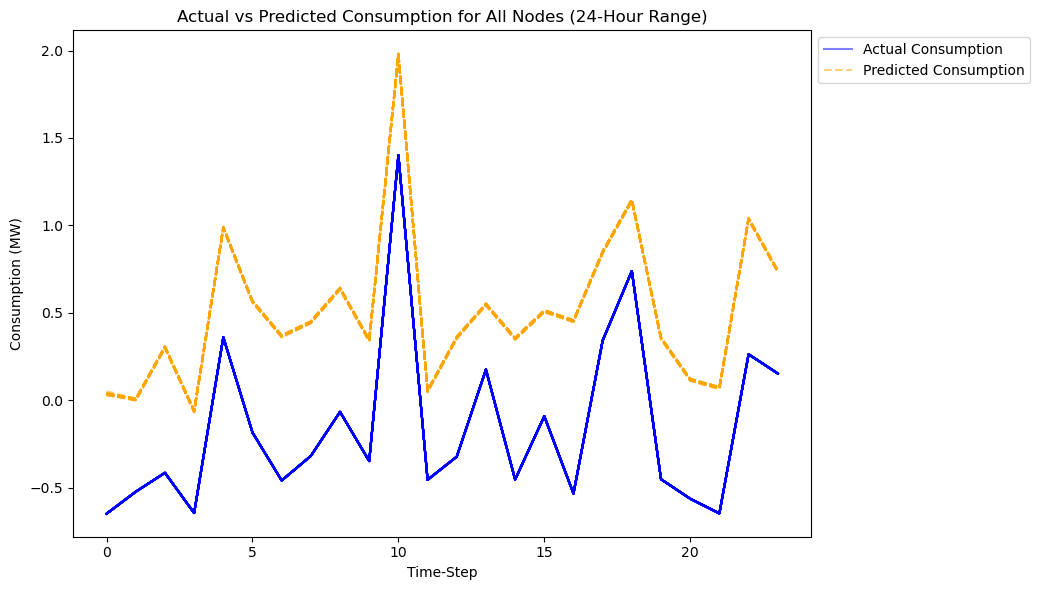

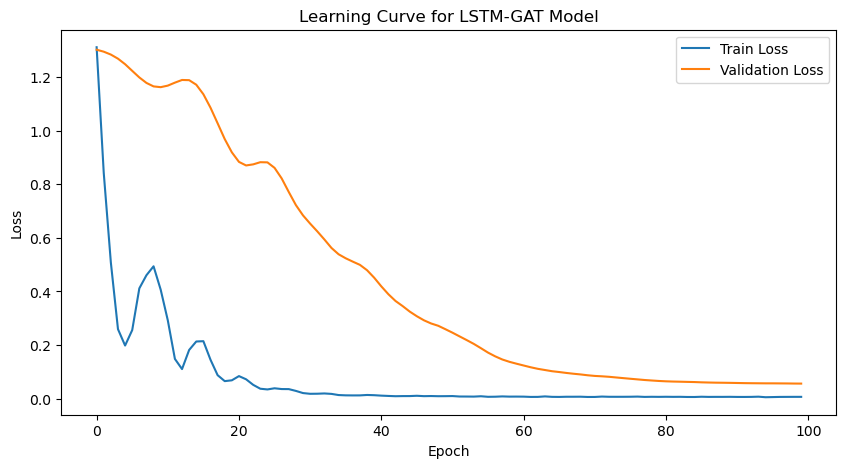

In [23]:
# Debugging prints
print("Shape of test_predictions:", test_predictions.shape)
print("Shape of test_targets:", test_targets.shape)

# Plotting the predictions vs. actual values for a specific 24-hour range for all nodes
range_hours = 24

# Ensure there are enough samples for the specified range
if test_predictions.shape[0] >= range_hours and test_targets.shape[0] >= range_hours:
    # Select any 24-hour range
    range_start = 0  # Change this to specify different starting points
    range_end = range_start + range_hours

    selected_predictions = test_predictions[range_start:range_end, :]
    selected_targets = test_targets[range_start:range_end, :]

    # Plotting
    fig, ax = plt.subplots(figsize=(14, 6))

    for node_index in range(selected_predictions.shape[1]):
        ax.plot(selected_targets[:, node_index], label='Actual Consumption' if node_index == 0 else "", color='blue', alpha=0.5)
        ax.plot(selected_predictions[:, node_index], label='Predicted Consumption' if node_index == 0 else "", linestyle='dashed', color='orange', alpha=0.5)
    
    ax.set_title(f'Actual vs Predicted Consumption for All Nodes ({range_hours}-Hour Range)')
    ax.set_xlabel('Time-Step')
    ax.set_ylabel('Consumption (MW)')
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=1)

    plt.tight_layout(rect=[0, 0, 0.75, 1])
    plt.show()
else:
    print(f"Not enough samples to plot the {range_hours}-hour range.")

# Plotting the learning curves
plt.figure(figsize=(10, 5))
plt.plot(best_train_losses, label='Train Loss')
plt.plot(best_val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve for LSTM-GAT Model')
plt.legend()
plt.show()


In [31]:
import matplotlib.pyplot as plt

# Debugging prints
print("Shape of test_predictions:", test_predictions.shape)
print("Shape of test_targets:", test_targets.shape)

# Plotting the predictions vs. actual values for a specific 24-hour range for all nodes
range_hours = 24

# Ensure there are enough samples for the specified range
if test_predictions.shape[0] >= range_hours and test_targets.shape[0] >= range_hours:
    # Select any 24-hour range
    range_start = 0  # Change this to specify different starting points
    range_end = range_start + range_hours

    selected_predictions = test_predictions[range_start:range_end, :]
    selected_targets = test_targets[range_start:range_end, :]

    # Plotting
    fig, ax = plt.subplots(figsize=(14, 6))

    for node_index in range(selected_predictions.shape[1]):
        ax.plot(selected_targets[:, node_index], label='Actual Consumption' if node_index == 0 else "", color='blue', alpha=0.5)
        ax.plot(selected_predictions[:, node_index], label='Predicted Consumption' if node_index == 0 else "", linestyle='dashed', color='orange', alpha=0.5)
    
    ax.set_title(f'LSTM-GAT Model Actual vs Predicted Consumption for All Nodes ({range_hours}-Hour Range)')
    ax.set_xlabel('Time-Step')
    ax.set_ylabel('Consumption (MW)')
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=1)

    plt.tight_layout(rect=[0, 0, 0.75, 1])
    plt.savefig('actual_vs_predicted_consumption.png')
    plt.close()
else:
    print(f"Not enough samples to plot the {range_hours}-hour range.")

# Plotting the learning curves
plt.figure(figsize=(10, 5))
plt.plot(best_train_losses, label='Train Loss')
plt.plot(best_val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve for LSTM-GAT Model')
plt.legend()
plt.savefig('learning_curve.png')
plt.close()


Shape of test_predictions: (27, 27, 1)
Shape of test_targets: (27, 27, 1)


In [27]:
gdtadhgwgfetheht

NameError: name 'gdtadhgwgfetheht' is not defined

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.nn as pyg_nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import logging
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold, ParameterSampler
from torch.optim.lr_scheduler import OneCycleLR, ReduceLROnPlateau

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the model
class LSTM_GAT_Model(nn.Module):
    def __init__(self, static_input_dim, lstm_input_dim, lstm_hidden_dim, lstm_num_layers, gat_input_dim, gat_hidden_dim, num_heads, combined_dim, output_dim, lstm_dropout=0.3, gat_dropout=0.3):
        super(LSTM_GAT_Model, self).__init__()

        # LSTM for time series features
        self.lstm = nn.LSTM(lstm_input_dim, lstm_hidden_dim, lstm_num_layers, batch_first=True, dropout=lstm_dropout if lstm_num_layers > 1 else 0.0)
        self.lstm_bn = nn.BatchNorm1d(lstm_hidden_dim)

        # Attention mechanism
        self.attention = nn.Linear(lstm_hidden_dim, 1)

        # Fully connected layer to combine LSTM output with static features
        self.fc1 = nn.Linear(lstm_hidden_dim + static_input_dim, gat_input_dim)
        self.fc1_bn = nn.BatchNorm1d(gat_input_dim)
        self.dropout1 = nn.Dropout(lstm_dropout)

        # GAT for combined features
        self.gat = pyg_nn.GATConv(gat_input_dim, gat_hidden_dim, heads=num_heads)
        self.gat_bn = nn.BatchNorm1d(gat_hidden_dim * num_heads)
        self.dropout2 = nn.Dropout(gat_dropout)

        # Fully connected layer for final output
        self.fc2 = nn.Linear(gat_hidden_dim * num_heads + gat_input_dim, combined_dim)  # Adjusted for skip connection
        self.fc2_bn = nn.BatchNorm1d(combined_dim)
        self.fc3 = nn.Linear(combined_dim, output_dim)

    def forward(self, data, sequences):
        sequences = sequences.to(device)
        data = data.to(device)

        # LSTM forward pass
        lstm_out, _ = self.lstm(sequences)
        lstm_out = lstm_out[:, -1, :]  # Use the last hidden state from LSTM
        lstm_out = self.lstm_bn(lstm_out)

        # Attention mechanism
        attn_weights = F.softmax(self.attention(lstm_out), dim=1)
        attn_out = torch.sum(lstm_out.unsqueeze(1) * attn_weights.unsqueeze(2), dim=1)  # Weighted sum of LSTM outputs

        # Ensure data.x has the correct shape and expand it to match the batch size
        static_features = data.x.unsqueeze(0).expand(sequences.size(0), -1, -1)  # (batch_size, num_nodes, static_input_dim)

        # Combine LSTM output with static features
        attn_out_expanded = attn_out.unsqueeze(1).expand(-1, static_features.size(1), -1)  # (batch_size, num_nodes, lstm_hidden_dim)
        combined_features = torch.cat([attn_out_expanded, static_features], dim=2)  # Concatenate along the feature dimension

        # Fully connected layer to reduce dimension
        combined_features = combined_features.view(-1, combined_features.size(2))  # Flatten batch and num_nodes dimensions
        combined_features = self.fc1(combined_features)
        combined_features = self.fc1_bn(combined_features)
        combined_features = self.dropout1(combined_features)

        # GAT forward pass
        gat_out = self.gat(combined_features, data.edge_index, data.edge_attr)
        gat_out = self.gat_bn(gat_out)
        gat_out = self.dropout2(gat_out)

        # Combine GAT outputs with the original combined features (skip connection)
        combined_gat = torch.cat([gat_out, combined_features], dim=1)

        # Fully connected layers for final output
        combined_gat = self.fc2(combined_gat)
        combined_gat = self.fc2_bn(combined_gat)
        output = self.fc3(combined_gat)

        output = output.view(sequences.size(0), -1, self.fc3.out_features)  # Reshape to (batch_size, num_nodes, output_dim)
        return output  # Return node-specific outputs

# Compute metrics
def compute_metrics(output, target, criterion):
    mse = criterion(output, target).item()
    rmse = np.sqrt(mse)
    mae = torch.mean(torch.abs(output - target)).item()
    mape = torch.mean(torch.abs((output - target) / (target + 1e-5))).item() * 100
    return mse, rmse, mae, mape

# Hyperparameter space for random search
param_distributions = {
    'lstm_hidden_dim': [64, 128, 256],
    'lstm_num_layers': [1, 2, 3],
    'gat_hidden_dim': [32, 64, 128],
    'num_heads': [4, 8, 16],
    'combined_dim': [64, 128, 256],
    'lstm_dropout': [0.1, 0.2, 0.3],
    'gat_dropout': [0.1, 0.2, 0.3],
    'learning_rate': [0.001, 0.0005, 0.0001],
    'weight_decay': [1e-4, 5e-4, 1e-3]
}

# K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Define test_loader outside the function
test_loader = DataLoader(TensorDataset(test_sequences_tensor, test_targets_tensor), batch_size=48, shuffle=False)

# Training and evaluation function with cross-validation
def cross_val_evaluate(param_sample, graph_data):
    lstm_hidden_dim = param_sample['lstm_hidden_dim']
    lstm_num_layers = param_sample['lstm_num_layers']
    gat_hidden_dim = param_sample['gat_hidden_dim']
    num_heads = param_sample['num_heads']
    combined_dim = param_sample['combined_dim']
    lstm_dropout = param_sample['lstm_dropout']
    gat_dropout = param_sample['gat_dropout']
    learning_rate = param_sample['learning_rate']
    weight_decay = param_sample['weight_decay']

    model = LSTM_GAT_Model(
        static_input_dim=8,
        lstm_input_dim=27,
        lstm_hidden_dim=lstm_hidden_dim,
        lstm_num_layers=lstm_num_layers,
        gat_input_dim=lstm_hidden_dim + 8,  # Corrected static_input_dim here
        gat_hidden_dim=gat_hidden_dim,
        num_heads=num_heads,
        combined_dim=combined_dim,
        output_dim=1,
        lstm_dropout=lstm_dropout,
        gat_dropout=gat_dropout
    ).to(device)  # Move model to device

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    num_epochs = 100
    batch_size = 48
    early_stopping_patience = 20
    best_val_loss = float('inf')
    epochs_no_improve = 0

    aggregated_metrics = {'mse': [], 'rmse': [], 'mae': [], 'mape': [], 'r2': []}

    for train_index, val_index in kf.split(train_sequences_tensor):
        train_sequences, val_sequences = train_sequences_tensor[train_index].to(device), train_sequences_tensor[val_index].to(device)
        train_targets, val_targets = train_targets_tensor[train_index].to(device), train_targets_tensor[val_index].to(device)

        train_loader = DataLoader(TensorDataset(train_sequences, train_targets), batch_size=batch_size, shuffle=False)
        val_loader = DataLoader(TensorDataset(val_sequences, val_targets), batch_size=batch_size, shuffle=False)

        # Initialize the scheduler here, after train_loader is defined
        scheduler = OneCycleLR(optimizer, max_lr=learning_rate, epochs=num_epochs, steps_per_epoch=len(train_loader))

        # Lists to store losses
        train_losses = []
        val_losses = []

        # Training loop
        for epoch in range(num_epochs):
            model.train()
            train_loss = 0
            for sequences, targets in train_loader:
                sequences, targets = sequences.to(device), targets.to(device)
                optimizer.zero_grad()
                output = model(graph_data, sequences)

                # Ensure the target shape matches the output shape
                targets_expanded = targets.unsqueeze(1).expand(-1, output.size(1), -1)  # Shape should be (batch_size, num_nodes, 1)

                loss = criterion(output, targets_expanded)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()

            # Validation
            model.eval()
            val_loss = 0
            with torch.no_grad():
                for sequences, targets in val_loader:
                    sequences, targets = sequences.to(device), targets.to(device)
                    output = model(graph_data, sequences)

                    # Ensure the target shape matches the output shape
                    targets_expanded = targets.unsqueeze(1).expand(-1, output.size(1), -1)  # Shape should be (batch_size, num_nodes, 1)

                    loss = criterion(output, targets_expanded)
                    val_loss += loss.item()

            train_loss /= len(train_loader)
            val_loss /= len(val_loader)
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            logging.info(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss}, Val Loss: {val_loss}')

            # Learning rate scheduling
            scheduler.step()

            # Early stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                epochs_no_improve = 0
                torch.save(model.state_dict(), 'best_model.pth')
            else:
                epochs_no_improve += 1
                if epochs_no_improve >= early_stopping_patience:
                    logging.info('Early stopping triggered')
                    break

        # Load the best model
        model.load_state_dict(torch.load('best_model.pth'))

        # Validation evaluation
        model.eval()
        val_mse, val_rmse, val_mae, val_mape = 0, 0, 0, 0
        all_predictions = []
        all_targets = []
        with torch.no_grad():
            for sequences, targets in val_loader:
                sequences, targets = sequences.to(device), targets.to(device)
                output = model(graph_data, sequences)

                # Ensure the target shape matches the output shape
                targets_expanded = targets.unsqueeze(1).expand(-1, output.size(1), -1)  # Shape should be (batch_size, num_nodes, 1)

                mse, rmse, mae, mape = compute_metrics(output, targets_expanded, criterion)
                val_mse += mse
                val_rmse += rmse
                val_mae += mae
                val_mape += mape

                all_predictions.append(output.cpu().numpy())
                all_targets.append(targets_expanded.cpu().numpy())

        # Compute overall R-squared
        all_predictions = np.vstack(all_predictions)
        all_targets = np.vstack(all_targets)

        # Flatten the arrays to 2D for r2_score computation
        all_predictions_flat = all_predictions.reshape(-1, 1)
        all_targets_flat = all_targets.reshape(-1, 1)

        val_r2 = r2_score(all_targets_flat, all_predictions_flat)

        val_mse /= len(val_loader)
        val_rmse /= len(val_loader)
        val_mae /= len(val_loader)
        val_mape /= len(val_loader)

        aggregated_metrics['mse'].append(val_mse)
        aggregated_metrics['rmse'].append(val_rmse)
        aggregated_metrics['mae'].append(val_mae)
        aggregated_metrics['mape'].append(val_mape)
        aggregated_metrics['r2'].append(val_r2)

    avg_metrics = {metric: np.mean(aggregated_metrics[metric]) for metric in aggregated_metrics}
    logging.info(f'Avg Validation Metrics: {avg_metrics}')

    return avg_metrics

# Random search for hyperparameter tuning
param_samples = list(ParameterSampler(param_distributions, n_iter=20, random_state=42))
best_score = float('inf')
best_params = None

for param_sample in param_samples:
    avg_metrics = cross_val_evaluate(param_sample, graph_data)
    if avg_metrics['mse'] < best_score:
        best_score = avg_metrics['mse']
        best_params = param_sample

print(f'Best Score: {best_score}')
print(f'Best Parameters: {best_params}')

# Train on the full training set with the best hyperparameters
def train_on_full_train_set(best_params, graph_data):
    lstm_hidden_dim = best_params['lstm_hidden_dim']
    lstm_num_layers = best_params['lstm_num_layers']
    gat_hidden_dim = best_params['gat_hidden_dim']
    num_heads = best_params['num_heads']
    combined_dim = best_params['combined_dim']
    lstm_dropout = best_params['lstm_dropout']
    gat_dropout = best_params['gat_dropout']
    learning_rate = best_params['learning_rate']
    weight_decay = best_params['weight_decay']
    num_epochs = 100  # Define num_epochs
    batch_size = 48  # Define batch_size

    model = LSTM_GAT_Model(
        static_input_dim=8,
        lstm_input_dim=27,
        lstm_hidden_dim=lstm_hidden_dim,
        lstm_num_layers=lstm_num_layers,
        gat_input_dim=lstm_hidden_dim + 8,  # Corrected static_input_dim here
        gat_hidden_dim=gat_hidden_dim,
        num_heads=num_heads,
        combined_dim=combined_dim,
        output_dim=1,
        lstm_dropout=lstm_dropout,
        gat_dropout=gat_dropout
    ).to(device)  # Move model to device

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    train_loader = DataLoader(TensorDataset(train_sequences_tensor, train_targets_tensor), batch_size=batch_size, shuffle=False)

    # Initialize the scheduler here, after train_loader is defined
    scheduler = OneCycleLR(optimizer, max_lr=learning_rate, epochs=num_epochs, steps_per_epoch=len(train_loader))

    early_stopping_patience = 20
    best_val_loss = float('inf')
    epochs_no_improve = 0

    val_loader = DataLoader(TensorDataset(val_sequences_tensor, val_targets_tensor), batch_size=batch_size, shuffle=False)

    # Lists to store losses
    train_losses = []
    val_losses = []

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for sequences, targets in train_loader:
            sequences, targets = sequences.to(device), targets.to(device)
            optimizer.zero_grad()
            output = model(graph_data, sequences)

            # Ensure the target shape matches the output shape
            targets_expanded = targets.unsqueeze(1).expand(-1, output.size(1), -1)  # Shape should be (batch_size, num_nodes, 1)

            loss = criterion(output, targets_expanded)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for sequences, targets in val_loader:
                sequences, targets = sequences.to(device), targets.to(device)
                output = model(graph_data, sequences)

                # Ensure the target shape matches the output shape
                targets_expanded = targets.unsqueeze(1).expand(-1, output.size(1), -1)  # Shape should be (batch_size, num_nodes, 1)

                loss = criterion(output, targets_expanded)
                val_loss += loss.item()

        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        logging.info(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss}, Val Loss: {val_loss}')

        # Learning rate scheduling
        scheduler.step()

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), 'best_model_full_train.pth')
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= early_stopping_patience:
                logging.info('Early stopping triggered')
                break

    # Load the best model
    model.load_state_dict(torch.load('best_model_full_train.pth'))

    return model, train_losses, val_losses

best_model, best_train_losses, best_val_losses = train_on_full_train_set(best_params, graph_data)

# Test evaluation
def evaluate_on_test_set(model, graph_data, criterion):
    model.eval()
    test_mse, test_rmse, test_mae, test_mape = 0, 0, 0, 0
    all_predictions = []
    all_targets = []
    with torch.no_grad():
        for sequences, targets in test_loader:
            sequences, targets = sequences.to(device), targets.to(device)
            output = model(graph_data, sequences)

            # Ensure the target shape matches the output shape
            targets_expanded = targets.unsqueeze(1).expand(-1, output.size(1), -1)  # Shape should be (batch_size, num_nodes, 1)

            mse, rmse, mae, mape = compute_metrics(output, targets_expanded, criterion)
            test_mse += mse
            test_rmse += rmse
            test_mae += mae
            test_mape += mape

            all_predictions.append(output.cpu().numpy())
            all_targets.append(targets_expanded.cpu().numpy())

    # Compute overall R-squared
    all_predictions = np.vstack(all_predictions)
    all_targets = np.vstack(all_targets)

    # Flatten the arrays to 2D for r2_score computation
    all_predictions_flat = all_predictions.reshape(-1, 1)
    all_targets_flat = all_targets.reshape(-1, 1)

    test_r2 = r2_score(all_targets_flat, all_predictions_flat)

    test_mse /= len(test_loader)
    test_rmse /= len(test_loader)
    test_mae /= len(test_loader)
    test_mape /= len(test_loader)

    logging.info(f'Test MSE: {test_mse}, Test RMSE: {test_rmse}, Test MAE: {test_mae}, Test MAPE: {test_mape}, Test R2: {test_r2}')

    return (test_mse, test_rmse, test_mae, test_mape, test_r2), all_predictions, all_targets

# Pass criterion as an argument
test_metrics, test_predictions, test_targets = evaluate_on_test_set(best_model, graph_data, nn.MSELoss())

# Debugging prints
print(f'Test Metrics: {test_metrics}')
print("Shape of test_predictions:", test_predictions.shape)
print("Shape of test_targets:", test_targets.shape)

# Plotting the predictions vs. actual values for the last 24 hours
last_hours = 24

if test_predictions.shape[0] >= last_hours and test_targets.shape[0] >= last_hours:
    last_predictions = test_predictions[-last_hours:, :]
    last_targets = test_targets[-last_hours:, :]
    node_index = 24

    plt.figure(figsize=(12, 8))
    plt.plot(last_targets[:, node_index], label=f'Actual Node {node_index}')
    plt.plot(last_predictions[:, node_index], label=f'Predicted Node {node_index}', linestyle='dashed')

    plt.xlabel('Time-Step')
    plt.ylabel('Consumption')
    plt.title(f'LSTM-GAT Model Predicted vs Actual Consumption for Node {node_index} (Last {last_hours} Hours)')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=1)
    plt.tight_layout(rect=[0, 0, 0.75, 1])
    plt.show()
else:
    print(f"Not enough samples to plot the last {last_hours} hours.")

# Plotting the learning curves
plt.figure(figsize=(10, 5))
plt.plot(best_train_losses, label='Train Loss')
plt.plot(best_val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve for LSTM-GAT Model')
plt.legend()
plt.show()


In [ ]:
ioyhiuggtcykjk

## LSTM-GAT + skip con + LSTM-attn

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.nn as pyg_nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import logging
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold, ParameterSampler
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the model
class LSTM_GAT_Model(nn.Module):
    def __init__(self, static_input_dim, lstm_input_dim, lstm_hidden_dim, lstm_num_layers, gat_input_dim, gat_hidden_dim, num_heads, combined_dim, output_dim, lstm_dropout=0.3, gat_dropout=0.3):
        super(LSTM_GAT_Model, self).__init__()

        # LSTM for time series features
        self.lstm = nn.LSTM(lstm_input_dim, lstm_hidden_dim, lstm_num_layers, batch_first=True, dropout=lstm_dropout if lstm_num_layers > 1 else 0.0)

        # Attention mechanism
        self.attention = nn.Linear(lstm_hidden_dim, 1)

        # Fully connected layer to combine LSTM output with static features
        self.fc1 = nn.Linear(lstm_hidden_dim + static_input_dim, gat_input_dim)
        self.dropout1 = nn.Dropout(lstm_dropout)

        # GAT for combined features
        self.gat = pyg_nn.GATConv(gat_input_dim, gat_hidden_dim, heads=num_heads)
        self.dropout2 = nn.Dropout(gat_dropout)

        # Fully connected layer for final output
        self.fc2 = nn.Linear(gat_hidden_dim * num_heads + gat_input_dim, combined_dim)  # Adjusted for skip connection
        self.fc3 = nn.Linear(combined_dim, output_dim)

    def forward(self, data, sequences):
        sequences = sequences.to(device)
        data = data.to(device)

        # LSTM forward pass
        lstm_out, _ = self.lstm(sequences)
        
        # Attention mechanism
        attn_weights = F.softmax(self.attention(lstm_out), dim=1)
        attn_out = torch.sum(lstm_out * attn_weights, dim=1)  # Weighted sum of LSTM outputs

        # Ensure data.x has the correct shape and expand it to match the batch size
        static_features = data.x.unsqueeze(0).expand(sequences.size(0), -1, -1)  # (batch_size, num_nodes, static_input_dim)

        # Combine LSTM output with static features
        attn_out_expanded = attn_out.unsqueeze(1).expand(-1, static_features.size(1), -1)  # (batch_size, num_nodes, lstm_hidden_dim)
        combined_features = torch.cat([attn_out_expanded, static_features], dim=2)  # Concatenate along the feature dimension

        # Fully connected layer to reduce dimension
        combined_features = combined_features.view(-1, combined_features.size(2))  # Flatten batch and num_nodes dimensions
        combined_features = self.fc1(combined_features)
        combined_features = self.dropout1(combined_features)

        # GAT forward pass
        gat_out = self.gat(combined_features, data.edge_index, data.edge_attr)
        gat_out = self.dropout2(gat_out)

        # Combine GAT outputs with the original combined features (skip connection)
        combined_gat = torch.cat([gat_out, combined_features], dim=1)

        # Fully connected layers for final output
        combined_gat = self.fc2(combined_gat)
        output = self.fc3(combined_gat)

        output = output.view(sequences.size(0), -1, self.fc3.out_features)  # Reshape to (batch_size, num_nodes, output_dim)
        return output  # Return node-specific outputs

# Compute metrics
def compute_metrics(output, target, criterion):
    mse = criterion(output, target).item()
    rmse = np.sqrt(mse)
    mae = torch.mean(torch.abs(output - target)).item()
    mape = torch.mean(torch.abs((output - target) / (target + 1e-5))).item() * 100
    return mse, rmse, mae, mape

# Hyperparameter space for random search
param_distributions = {
    'lstm_hidden_dim': [64, 128, 256],
    'lstm_num_layers': [1, 2, 3],
    'gat_hidden_dim': [32, 64, 128],
    'num_heads': [4, 8, 16],
    'combined_dim': [64, 128, 256],
    'lstm_dropout': [0.1, 0.2, 0.3],
    'gat_dropout': [0.1, 0.2, 0.3],
    'learning_rate': [0.001, 0.0005, 0.0001],
    'weight_decay': [1e-4, 5e-4, 1e-3]
}

# K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Define test_loader outside the function
test_loader = DataLoader(TensorDataset(test_sequences_tensor, test_targets_tensor), batch_size=48, shuffle=False)

# Training and evaluation function with cross-validation
def cross_val_evaluate(param_sample, graph_data):
    lstm_hidden_dim = param_sample['lstm_hidden_dim']
    lstm_num_layers = param_sample['lstm_num_layers']
    gat_hidden_dim = param_sample['gat_hidden_dim']
    num_heads = param_sample['num_heads']
    combined_dim = param_sample['combined_dim']
    lstm_dropout = param_sample['lstm_dropout']
    gat_dropout = param_sample['gat_dropout']
    learning_rate = param_sample['learning_rate']
    weight_decay = param_sample['weight_decay']

    model = LSTM_GAT_Model(
        static_input_dim=8,
        lstm_input_dim=27,
        lstm_hidden_dim=lstm_hidden_dim,
        lstm_num_layers=lstm_num_layers,
        gat_input_dim=lstm_hidden_dim + 8,  # Corrected static_input_dim here
        gat_hidden_dim=gat_hidden_dim,
        num_heads=num_heads,
        combined_dim=combined_dim,
        output_dim=1,
        lstm_dropout=lstm_dropout,
        gat_dropout=gat_dropout
    ).to(device)  # Move model to device

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

    num_epochs = 100
    batch_size = 48
    early_stopping_patience = 20
    best_val_loss = float('inf')
    epochs_no_improve = 0

    aggregated_metrics = {'mse': [], 'rmse': [], 'mae': [], 'mape': [], 'r2': []}

    for train_index, val_index in kf.split(train_sequences_tensor):
        train_sequences, val_sequences = train_sequences_tensor[train_index].to(device), train_sequences_tensor[val_index].to(device)
        train_targets, val_targets = train_targets_tensor[train_index].to(device), train_targets_tensor[val_index].to(device)

        train_loader = DataLoader(TensorDataset(train_sequences, train_targets), batch_size=batch_size, shuffle=False)
        val_loader = DataLoader(TensorDataset(val_sequences, val_targets), batch_size=batch_size, shuffle=False)

        # Lists to store losses
        train_losses = []
        val_losses = []

        # Training loop
        for epoch in range(num_epochs):
            model.train()
            train_loss = 0
            for sequences, targets in train_loader:
                sequences, targets = sequences.to(device), targets.to(device)
                optimizer.zero_grad()
                output = model(graph_data, sequences)

                # Ensure the target shape matches the output shape
                targets_expanded = targets.unsqueeze(1).expand(-1, output.size(1), -1)  # Shape should be (batch_size, num_nodes, 1)

                loss = criterion(output, targets_expanded)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()

            # Validation
            model.eval()
            val_loss = 0
            with torch.no_grad():
                for sequences, targets in val_loader:
                    sequences, targets = sequences.to(device), targets.to(device)
                    output = model(graph_data, sequences)

                    # Ensure the target shape matches the output shape
                    targets_expanded = targets.unsqueeze(1).expand(-1, output.size(1), -1)  # Shape should be (batch_size, num_nodes, 1)

                    loss = criterion(output, targets_expanded)
                    val_loss += loss.item()

            train_loss /= len(train_loader)
            val_loss /= len(val_loader)
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            logging.info(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss}, Val Loss: {val_loss}')

            # Learning rate scheduling
            scheduler.step(val_loss)

            # Early stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                epochs_no_improve = 0
                torch.save(model.state_dict(), 'best_model.pth')
            else:
                epochs_no_improve += 1
                if epochs_no_improve >= early_stopping_patience:
                    logging.info('Early stopping triggered')
                    break

        # Load the best model
        model.load_state_dict(torch.load('best_model.pth'))

        # Validation evaluation
        model.eval()
        val_mse, val_rmse, val_mae, val_mape = 0, 0, 0, 0
        all_predictions = []
        all_targets = []
        with torch.no_grad():
            for sequences, targets in val_loader:
                sequences, targets = sequences.to(device), targets.to(device)
                output = model(graph_data, sequences)

                # Ensure the target shape matches the output shape
                targets_expanded = targets.unsqueeze(1).expand(-1, output.size(1), -1)  # Shape should be (batch_size, num_nodes, 1)

                mse, rmse, mae, mape = compute_metrics(output, targets_expanded, criterion)
                val_mse += mse
                val_rmse += rmse
                val_mae += mae
                val_mape += mape

                all_predictions.append(output.cpu().numpy())
                all_targets.append(targets_expanded.cpu().numpy())

        # Compute overall R-squared
        all_predictions = np.vstack(all_predictions)
        all_targets = np.vstack(all_targets)

        # Flatten the arrays to 2D for r2_score computation
        all_predictions_flat = all_predictions.reshape(-1, 1)
        all_targets_flat = all_targets.reshape(-1, 1)

        val_r2 = r2_score(all_targets_flat, all_predictions_flat)

        val_mse /= len(val_loader)
        val_rmse /= len(val_loader)
        val_mae /= len(val_loader)
        val_mape /= len(val_loader)

        aggregated_metrics['mse'].append(val_mse)
        aggregated_metrics['rmse'].append(val_rmse)
        aggregated_metrics['mae'].append(val_mae)
        aggregated_metrics['mape'].append(val_mape)
        aggregated_metrics['r2'].append(val_r2)

    avg_metrics = {metric: np.mean(aggregated_metrics[metric]) for metric in aggregated_metrics}
    logging.info(f'Avg Validation Metrics: {avg_metrics}')

    return avg_metrics

# Random search for hyperparameter tuning
param_samples = list(ParameterSampler(param_distributions, n_iter=20, random_state=42))
best_score = float('inf')
best_params = None

for param_sample in param_samples:
    avg_metrics = cross_val_evaluate(param_sample, graph_data)
    if avg_metrics['mse'] < best_score:
        best_score = avg_metrics['mse']
        best_params = param_sample

print(f'Best Score: {best_score}')
print(f'Best Parameters: {best_params}')

# Train on the full training set with the best hyperparameters
def train_on_full_train_set(best_params, graph_data):
    lstm_hidden_dim = best_params['lstm_hidden_dim']
    lstm_num_layers = best_params['lstm_num_layers']
    gat_hidden_dim = best_params['gat_hidden_dim']
    num_heads = best_params['num_heads']
    combined_dim = best_params['combined_dim']
    lstm_dropout = best_params['lstm_dropout']
    gat_dropout = best_params['gat_dropout']
    learning_rate = best_params['learning_rate']
    weight_decay = best_params['weight_decay']

    model = LSTM_GAT_Model(
        static_input_dim=8,
        lstm_input_dim=27,
        lstm_hidden_dim=lstm_hidden_dim,
        lstm_num_layers=lstm_num_layers,
        gat_input_dim=lstm_hidden_dim + 8,  # Corrected static_input_dim here
        gat_hidden_dim=gat_hidden_dim,
        num_heads=num_heads,
        combined_dim=combined_dim,
        output_dim=1,
        lstm_dropout=lstm_dropout,
        gat_dropout=gat_dropout
    ).to(device)  # Move model to device

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

    num_epochs = 100
    batch_size = 48
    early_stopping_patience = 20
    best_val_loss = float('inf')
    epochs_no_improve = 0

    train_loader = DataLoader(TensorDataset(train_sequences_tensor, train_targets_tensor), batch_size=batch_size, shuffle=False)
    val_loader = DataLoader(TensorDataset(val_sequences_tensor, val_targets_tensor), batch_size=batch_size, shuffle=False)

    # Lists to store losses
    train_losses = []
    val_losses = []

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for sequences, targets in train_loader:
            sequences, targets = sequences.to(device), targets.to(device)
            optimizer.zero_grad()
            output = model(graph_data, sequences)

            # Ensure the target shape matches the output shape
            targets_expanded = targets.unsqueeze(1).expand(-1, output.size(1), -1)  # Shape should be (batch_size, num_nodes, 1)

            loss = criterion(output, targets_expanded)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for sequences, targets in val_loader:
                sequences, targets = sequences.to(device), targets.to(device)
                output = model(graph_data, sequences)

                # Ensure the target shape matches the output shape
                targets_expanded = targets.unsqueeze(1).expand(-1, output.size(1), -1)  # Shape should be (batch_size, num_nodes, 1)

                loss = criterion(output, targets_expanded)
                val_loss += loss.item()

        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        logging.info(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss}, Val Loss: {val_loss}')

        # Learning rate scheduling
        scheduler.step(val_loss)

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), 'best_model_full_train.pth')
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= early_stopping_patience:
                logging.info('Early stopping triggered')
                break

    # Load the best model
    model.load_state_dict(torch.load('best_model_full_train.pth'))

    return model, train_losses, val_losses

best_model, best_train_losses, best_val_losses = train_on_full_train_set(best_params, graph_data)

# Test evaluation
def evaluate_on_test_set(model, graph_data, criterion):
    model.eval()
    test_mse, test_rmse, test_mae, test_mape = 0, 0, 0, 0
    all_predictions = []
    all_targets = []
    with torch.no_grad():
        for sequences, targets in test_loader:
            sequences, targets = sequences.to(device), targets.to(device)
            output = model(graph_data, sequences)

            # Ensure the target shape matches the output shape
            targets_expanded = targets.unsqueeze(1).expand(-1, output.size(1), -1)  # Shape should be (batch_size, num_nodes, 1)

            mse, rmse, mae, mape = compute_metrics(output, targets_expanded, criterion)
            test_mse += mse
            test_rmse += rmse
            test_mae += mae
            test_mape += mape

            all_predictions.append(output.cpu().numpy())
            all_targets.append(targets_expanded.cpu().numpy())

    # Compute overall R-squared
    all_predictions = np.vstack(all_predictions)
    all_targets = np.vstack(all_targets)

    # Flatten the arrays to 2D for r2_score computation
    all_predictions_flat = all_predictions.reshape(-1, 1)
    all_targets_flat = all_targets.reshape(-1, 1)

    test_r2 = r2_score(all_targets_flat, all_predictions_flat)

    test_mse /= len(test_loader)
    test_rmse /= len(test_loader)
    test_mae /= len(test_loader)
    test_mape /= len(test_loader)

    logging.info(f'Test MSE: {test_mse}, Test RMSE: {test_rmse}, Test MAE: {test_mae}, Test MAPE: {test_mape}, Test R2: {test_r2}')

    return (test_mse, test_rmse, test_mae, test_mape, test_r2), all_predictions, all_targets

# Pass criterion as an argument
test_metrics, test_predictions, test_targets = evaluate_on_test_set(best_model, graph_data, nn.MSELoss())

# Debugging prints
print(f'Test Metrics: {test_metrics}')
print("Shape of test_predictions:", test_predictions.shape)
print("Shape of test_targets:", test_targets.shape)

# Plotting the predictions vs. actual values for the last 24 hours
last_hours = 24

if test_predictions.shape[0] >= last_hours and test_targets.shape[0] >= last_hours:
    last_predictions = test_predictions[-last_hours:, :]
    last_targets = test_targets[-last_hours:, :]
    node_index = 24

    plt.figure(figsize=(12, 8))
    plt.plot(last_targets[:, node_index], label=f'Actual Node {node_index}')
    plt.plot(last_predictions[:, node_index], label=f'Predicted Node {node_index}', linestyle='dashed')

    plt.xlabel('Time-Step')
    plt.ylabel('Consumption')
    plt.title(f'LSTM-GAT Model Predicted vs Actual Consumption for Node {node_index} (Last {last_hours} Hours)')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=1)
    plt.tight_layout(rect=[0, 0, 0.75, 1])
    plt.show()
else:
    print(f"Not enough samples to plot the last {last_hours} hours.")

# Plotting the learning curves
plt.figure(figsize=(10, 5))
plt.plot(best_train_losses, label='Train Loss')
plt.plot(best_val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve for LSTM-GAT Model')
plt.legend()
plt.show()


In [ ]:
# Debugging prints
print("Shape of test_predictions:", test_predictions.shape)
print("Shape of test_targets:", test_targets.shape)

# Plotting the predictions vs. actual values for a specific 24-hour range for all nodes
range_hours = 24

# Ensure there are enough samples for the specified range
if test_predictions.shape[0] >= range_hours and test_targets.shape[0] >= range_hours:
    # Select any 24-hour range
    range_start = 0  # Change this to specify different starting points
    range_end = range_start + range_hours

    selected_predictions = test_predictions[range_start:range_end, :]
    selected_targets = test_targets[range_start:range_end, :]

    # Plotting
    fig, ax = plt.subplots(figsize=(14, 6))

    for node_index in range(selected_predictions.shape[1]):
        ax.plot(selected_targets[:, node_index], label='Actual Consumption' if node_index == 0 else "", color='blue', alpha=0.5)
        ax.plot(selected_predictions[:, node_index], label='Predicted Consumption' if node_index == 0 else "", linestyle='dashed', color='orange', alpha=0.5)
    
    ax.set_title(f'Actual vs Predicted Consumption for All Nodes ({range_hours}-Hour Range)')
    ax.set_xlabel('Time-Step')
    ax.set_ylabel('Consumption (MW)')
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=1)

    plt.tight_layout(rect=[0, 0, 0.75, 1])
    plt.show()
else:
    print(f"Not enough samples to plot the {range_hours}-hour range.")

# Plotting the learning curves
plt.figure(figsize=(10, 5))
plt.plot(best_train_losses, label='Train Loss')
plt.plot(best_val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve for LSTM-GAT Model')
plt.legend()
plt.show()


In [ ]:
nmmnb

## LSTM-GAT (no skip connection and LSTM attention)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.nn as pyg_nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import logging
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold, ParameterSampler
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the model
class LSTM_GAT_Model(nn.Module):
    def __init__(self, static_input_dim, lstm_input_dim, lstm_hidden_dim, lstm_num_layers, gat_input_dim, gat_hidden_dim, num_heads, combined_dim, output_dim, lstm_dropout=0.3, gat_dropout=0.3):
        super(LSTM_GAT_Model, self).__init__()

        # LSTM for time series features
        self.lstm = nn.LSTM(lstm_input_dim, lstm_hidden_dim, lstm_num_layers, batch_first=True, dropout=lstm_dropout if lstm_num_layers > 1 else 0.0)

        # Fully connected layer to combine LSTM output with static features
        self.fc1 = nn.Linear(lstm_hidden_dim + static_input_dim, gat_input_dim)
        self.dropout1 = nn.Dropout(lstm_dropout)

        # GAT for combined features
        self.gat = pyg_nn.GATConv(gat_input_dim, gat_hidden_dim, heads=num_heads)
        self.dropout2 = nn.Dropout(gat_dropout)

        # Fully connected layer for final output
        self.fc2 = nn.Linear(gat_hidden_dim * num_heads, combined_dim)  # Adjusted for removing skip connection
        self.fc3 = nn.Linear(combined_dim, output_dim)

    def forward(self, data, sequences):
        sequences = sequences.to(device)
        data = data.to(device)

        # LSTM forward pass
        lstm_out, _ = self.lstm(sequences)
        lstm_out = lstm_out[:, -1, :]  # Take the last output of LSTM

        # Ensure data.x has the correct shape and expand it to match the batch size
        static_features = data.x.unsqueeze(0).expand(sequences.size(0), -1, -1)  # (batch_size, num_nodes, static_input_dim)

        # Combine LSTM output with static features
        lstm_out_expanded = lstm_out.unsqueeze(1).expand(-1, static_features.size(1), -1)  # (batch_size, num_nodes, lstm_hidden_dim)
        combined_features = torch.cat([lstm_out_expanded, static_features], dim=2)  # Concatenate along the feature dimension

        # Fully connected layer to reduce dimension
        combined_features = combined_features.view(-1, combined_features.size(2))  # Flatten batch and num_nodes dimensions
        combined_features = self.fc1(combined_features)
        combined_features = self.dropout1(combined_features)

        # GAT forward pass
        gat_out = self.gat(combined_features, data.edge_index, data.edge_attr)
        gat_out = self.dropout2(gat_out)

        # Fully connected layers for final output
        combined_gat = self.fc2(gat_out)
        output = self.fc3(combined_gat)

        output = output.view(sequences.size(0), -1, self.fc3.out_features)  # Reshape to (batch_size, num_nodes, output_dim)
        return output  # Return node-specific outputs

# Compute metrics
def compute_metrics(output, target, criterion):
    mse = criterion(output, target).item()
    rmse = np.sqrt(mse)
    mae = torch.mean(torch.abs(output - target)).item()
    mape = torch.mean(torch.abs((output - target) / (target + 1e-5))).item() * 100
    return mse, rmse, mae, mape

# Hyperparameter space for random search
param_distributions = {
    'lstm_hidden_dim': [64, 128, 256],
    'lstm_num_layers': [1, 2, 3],
    'gat_hidden_dim': [32, 64, 128],
    'num_heads': [4, 8, 16],
    'combined_dim': [64, 128, 256],
    'lstm_dropout': [0.1, 0.2, 0.3],
    'gat_dropout': [0.1, 0.2, 0.3],
    'learning_rate': [0.001, 0.0005, 0.0001],
    'weight_decay': [1e-4, 5e-4, 1e-3]
}

# K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Define test_loader outside the function
test_loader = DataLoader(TensorDataset(test_sequences_tensor, test_targets_tensor), batch_size=48, shuffle=False)

# Training and evaluation function with cross-validation
def cross_val_evaluate(param_sample, graph_data):
    lstm_hidden_dim = param_sample['lstm_hidden_dim']
    lstm_num_layers = param_sample['lstm_num_layers']
    gat_hidden_dim = param_sample['gat_hidden_dim']
    num_heads = param_sample['num_heads']
    combined_dim = param_sample['combined_dim']
    lstm_dropout = param_sample['lstm_dropout']
    gat_dropout = param_sample['gat_dropout']
    learning_rate = param_sample['learning_rate']
    weight_decay = param_sample['weight_decay']

    model = LSTM_GAT_Model(
        static_input_dim=8,
        lstm_input_dim=27,
        lstm_hidden_dim=lstm_hidden_dim,
        lstm_num_layers=lstm_num_layers,
        gat_input_dim=lstm_hidden_dim + 8,  # Corrected static_input_dim here
        gat_hidden_dim=gat_hidden_dim,
        num_heads=num_heads,
        combined_dim=combined_dim,
        output_dim=1,
        lstm_dropout=lstm_dropout,
        gat_dropout=gat_dropout
    ).to(device)  # Move model to device

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

    num_epochs = 100
    batch_size = 48
    early_stopping_patience = 20
    best_val_loss = float('inf')
    epochs_no_improve = 0

    aggregated_metrics = {'mse': [], 'rmse': [], 'mae': [], 'mape': [], 'r2': []}

    for train_index, val_index in kf.split(train_sequences_tensor):
        train_sequences, val_sequences = train_sequences_tensor[train_index].to(device), train_sequences_tensor[val_index].to(device)
        train_targets, val_targets = train_targets_tensor[train_index].to(device), train_targets_tensor[val_index].to(device)

        train_loader = DataLoader(TensorDataset(train_sequences, train_targets), batch_size=batch_size, shuffle=False)
        val_loader = DataLoader(TensorDataset(val_sequences, val_targets), batch_size=batch_size, shuffle=False)

        # Lists to store losses
        train_losses = []
        val_losses = []

        # Training loop
        for epoch in range(num_epochs):
            model.train()
            train_loss = 0
            for sequences, targets in train_loader:
                sequences, targets = sequences.to(device), targets.to(device)
                optimizer.zero_grad()
                output = model(graph_data, sequences)

                # Ensure the target shape matches the output shape
                targets_expanded = targets.unsqueeze(1).expand(-1, output.size(1), -1)  # Shape should be (batch_size, num_nodes, 1)

                loss = criterion(output, targets_expanded)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()

            # Validation
            model.eval()
            val_loss = 0
            with torch.no_grad():
                for sequences, targets in val_loader:
                    sequences, targets = sequences.to(device), targets.to(device)
                    output = model(graph_data, sequences)

                    # Ensure the target shape matches the output shape
                    targets_expanded = targets.unsqueeze(1).expand(-1, output.size(1), -1)  # Shape should be (batch_size, num_nodes, 1)

                    loss = criterion(output, targets_expanded)
                    val_loss += loss.item()

            train_loss /= len(train_loader)
            val_loss /= len(val_loader)
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            logging.info(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss}, Val Loss: {val_loss}')

            # Learning rate scheduling
            scheduler.step(val_loss)

            # Early stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                epochs_no_improve = 0
                torch.save(model.state_dict(), 'best_model.pth')
            else:
                epochs_no_improve += 1
                if epochs_no_improve >= early_stopping_patience:
                    logging.info('Early stopping triggered')
                    break

        # Load the best model
        model.load_state_dict(torch.load('best_model.pth'))

        # Validation evaluation
        model.eval()
        val_mse, val_rmse, val_mae, val_mape = 0, 0, 0, 0
        all_predictions = []
        all_targets = []
        with torch.no_grad():
            for sequences, targets in val_loader:
                sequences, targets = sequences.to(device), targets.to(device)
                output = model(graph_data, sequences)

                # Ensure the target shape matches the output shape
                targets_expanded = targets.unsqueeze(1).expand(-1, output.size(1), -1)  # Shape should be (batch_size, num_nodes, 1)

                mse, rmse, mae, mape = compute_metrics(output, targets_expanded, criterion)
                val_mse += mse
                val_rmse += rmse
                val_mae += mae
                val_mape += mape

                all_predictions.append(output.cpu().numpy())
                all_targets.append(targets_expanded.cpu().numpy())

        # Compute overall R-squared
        all_predictions = np.vstack(all_predictions)
        all_targets = np.vstack(all_targets)

        # Flatten the arrays to 2D for r2_score computation
        all_predictions_flat = all_predictions.reshape(-1, 1)
        all_targets_flat = all_targets.reshape(-1, 1)

        val_r2 = r2_score(all_targets_flat, all_predictions_flat)

        val_mse /= len(val_loader)
        val_rmse /= len(val_loader)
        val_mae /= len(val_loader)
        val_mape /= len(val_loader)

        aggregated_metrics['mse'].append(val_mse)
        aggregated_metrics['rmse'].append(val_rmse)
        aggregated_metrics['mae'].append(val_mae)
        aggregated_metrics['mape'].append(val_mape)
        aggregated_metrics['r2'].append(val_r2)

    avg_metrics = {metric: np.mean(aggregated_metrics[metric]) for metric in aggregated_metrics}
    logging.info(f'Avg Validation Metrics: {avg_metrics}')

    return avg_metrics

# Random search for hyperparameter tuning
param_samples = list(ParameterSampler(param_distributions, n_iter=20, random_state=42))
best_score = float('inf')
best_params = None

for param_sample in param_samples:
    avg_metrics = cross_val_evaluate(param_sample, graph_data)
    if avg_metrics['mse'] < best_score:
        best_score = avg_metrics['mse']
        best_params = param_sample

print(f'Best Score: {best_score}')
print(f'Best Parameters: {best_params}')

# Train on the full training set with the best hyperparameters
def train_on_full_train_set(best_params, graph_data):
    lstm_hidden_dim = best_params['lstm_hidden_dim']
    lstm_num_layers = best_params['lstm_num_layers']
    gat_hidden_dim = best_params['gat_hidden_dim']
    num_heads = best_params['num_heads']
    combined_dim = best_params['combined_dim']
    lstm_dropout = best_params['lstm_dropout']
    gat_dropout = best_params['gat_dropout']
    learning_rate = best_params['learning_rate']
    weight_decay = best_params['weight_decay']

    model = LSTM_GAT_Model(
        static_input_dim=8,
        lstm_input_dim=27,
        lstm_hidden_dim=lstm_hidden_dim,
        lstm_num_layers=lstm_num_layers,
        gat_input_dim=lstm_hidden_dim + 8,  # Corrected static_input_dim here
        gat_hidden_dim=gat_hidden_dim,
        num_heads=num_heads,
        combined_dim=combined_dim,
        output_dim=1,
        lstm_dropout=lstm_dropout,
        gat_dropout=gat_dropout
    ).to(device)  # Move model to device

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

    num_epochs = 100
    batch_size = 48
    early_stopping_patience = 20
    best_val_loss = float('inf')
    epochs_no_improve = 0

    train_loader = DataLoader(TensorDataset(train_sequences_tensor, train_targets_tensor), batch_size=batch_size, shuffle=False)
    val_loader = DataLoader(TensorDataset(val_sequences_tensor, val_targets_tensor), batch_size=batch_size, shuffle=False)

    # Lists to store losses
    train_losses = []
    val_losses = []

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for sequences, targets in train_loader:
            sequences, targets = sequences.to(device), targets.to(device)
            optimizer.zero_grad()
            output = model(graph_data, sequences)

            # Ensure the target shape matches the output shape
            targets_expanded = targets.unsqueeze(1).expand(-1, output.size(1), -1)  # Shape should be (batch_size, num_nodes, 1)

            loss = criterion(output, targets_expanded)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for sequences, targets in val_loader:
                sequences, targets = sequences.to(device), targets.to(device)
                output = model(graph_data, sequences)

                # Ensure the target shape matches the output shape
                targets_expanded = targets.unsqueeze(1).expand(-1, output.size(1), -1)  # Shape should be (batch_size, num_nodes, 1)

                loss = criterion(output, targets_expanded)
                val_loss += loss.item()

        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        logging.info(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss}, Val Loss: {val_loss}')

        # Learning rate scheduling
        scheduler.step(val_loss)

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), 'best_model_full_train.pth')
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= early_stopping_patience:
                logging.info('Early stopping triggered')
                break

    # Load the best model
    model.load_state_dict(torch.load('best_model_full_train.pth'))

    return model, train_losses, val_losses

best_model, best_train_losses, best_val_losses = train_on_full_train_set(best_params, graph_data)

# Test evaluation
def evaluate_on_test_set(model, graph_data, criterion):
    model.eval()
    test_mse, test_rmse, test_mae, test_mape = 0, 0, 0, 0
    all_predictions = []
    all_targets = []
    with torch.no_grad():
        for sequences, targets in test_loader:
            sequences, targets = sequences.to(device), targets.to(device)
            output = model(graph_data, sequences)

            # Ensure the target shape matches the output shape
            targets_expanded = targets.unsqueeze(1).expand(-1, output.size(1), -1)  # Shape should be (batch_size, num_nodes, 1)

            mse, rmse, mae, mape = compute_metrics(output, targets_expanded, criterion)
            test_mse += mse
            test_rmse += rmse
            test_mae += mae
            test_mape += mape

            all_predictions.append(output.cpu().numpy())
            all_targets.append(targets_expanded.cpu().numpy())

    # Compute overall R-squared
    all_predictions = np.vstack(all_predictions)
    all_targets = np.vstack(all_targets)

    # Flatten the arrays to 2D for r2_score computation
    all_predictions_flat = all_predictions.reshape(-1, 1)
    all_targets_flat = all_targets.reshape(-1, 1)

    test_r2 = r2_score(all_targets_flat, all_predictions_flat)

    test_mse /= len(test_loader)
    test_rmse /= len(test_loader)
    test_mae /= len(test_loader)
    test_mape /= len(test_loader)

    logging.info(f'Test MSE: {test_mse}, Test RMSE: {test_rmse}, Test MAE: {test_mae}, Test MAPE: {test_mape}, Test R2: {test_r2}')

    return (test_mse, test_rmse, test_mae, test_mape, test_r2), all_predictions, all_targets

# Pass criterion as an argument
test_metrics, test_predictions, test_targets = evaluate_on_test_set(best_model, graph_data, nn.MSELoss())

# Debugging prints
print(f'Test Metrics: {test_metrics}')
print("Shape of test_predictions:", test_predictions.shape)
print("Shape of test_targets:", test_targets.shape)

# Plotting the predictions vs. actual values for the last 24 hours
last_hours = 24

if test_predictions.shape[0] >= last_hours and test_targets.shape[0] >= last_hours:
    last_predictions = test_predictions[-last_hours:, :]
    last_targets = test_targets[-last_hours:, :]
    node_index = 24

    plt.figure(figsize=(12, 8))
    plt.plot(last_targets[:, node_index], label=f'Actual Node {node_index}')
    plt.plot(last_predictions[:, node_index], label=f'Predicted Node {node_index}', linestyle='dashed')

    plt.xlabel('Time-Step')
    plt.ylabel('Consumption')
    plt.title(f'LSTM-GAT Model Predicted vs Actual Consumption for Node {node_index} (Last {last_hours} Hours)')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=1)
    plt.tight_layout(rect=[0, 0, 0.75, 1])
    plt.show()
else:
    print(f"Not enough samples to plot the last {last_hours} hours.")

# Plotting the learning curves
plt.figure(figsize=(10, 5))
plt.plot(best_train_losses, label='Train Loss')
plt.plot(best_val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve for LSTM-GAT Model')
plt.legend()
plt.show()


In [ ]:
# Debugging prints
print("Shape of test_predictions:", test_predictions.shape)
print("Shape of test_targets:", test_targets.shape)

# Plotting the predictions vs. actual values for a specific 24-hour range for all nodes
range_hours = 24

# Ensure there are enough samples for the specified range
if test_predictions.shape[0] >= range_hours and test_targets.shape[0] >= range_hours:
    # Select any 24-hour range
    range_start = 0  # Change this to specify different starting points
    range_end = range_start + range_hours

    selected_predictions = test_predictions[range_start:range_end, :]
    selected_targets = test_targets[range_start:range_end, :]

    # Plotting
    fig, ax = plt.subplots(figsize=(14, 6))

    for node_index in range(selected_predictions.shape[1]):
        ax.plot(selected_targets[:, node_index], label='Actual Consumption' if node_index == 0 else "", color='blue', alpha=0.5)
        ax.plot(selected_predictions[:, node_index], label='Predicted Consumption' if node_index == 0 else "", linestyle='dashed', color='orange', alpha=0.5)
    
    ax.set_title(f'Actual vs Predicted Consumption for All Nodes ({range_hours}-Hour Range)')
    ax.set_xlabel('Time-Step')
    ax.set_ylabel('Consumption (MW)')
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=1)

    plt.tight_layout(rect=[0, 0, 0.75, 1])
    plt.show()
else:
    print(f"Not enough samples to plot the {range_hours}-hour range.")

# Plotting the learning curves
plt.figure(figsize=(10, 5))
plt.plot(best_train_losses, label='Train Loss')
plt.plot(best_val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve for LSTM-GAT Model')
plt.legend()
plt.show()


## LSTM-GAT + Skip connection (no LSTM attention)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.nn as pyg_nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import logging
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold, ParameterSampler
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the model
class LSTM_GAT_Model(nn.Module):
    def __init__(self, static_input_dim, lstm_input_dim, lstm_hidden_dim, lstm_num_layers, gat_input_dim, gat_hidden_dim, num_heads, combined_dim, output_dim, lstm_dropout=0.3, gat_dropout=0.3):
        super(LSTM_GAT_Model, self).__init__()

        # LSTM for time series features
        self.lstm = nn.LSTM(lstm_input_dim, lstm_hidden_dim, lstm_num_layers, batch_first=True, dropout=lstm_dropout if lstm_num_layers > 1 else 0.0)

        # Fully connected layer to combine LSTM output with static features
        self.fc1 = nn.Linear(lstm_hidden_dim + static_input_dim, gat_input_dim)
        self.dropout1 = nn.Dropout(lstm_dropout)

        # GAT for combined features
        self.gat = pyg_nn.GATConv(gat_input_dim, gat_hidden_dim, heads=num_heads)
        self.dropout2 = nn.Dropout(gat_dropout)

        # Fully connected layer for final output
        self.fc2 = nn.Linear(gat_hidden_dim * num_heads + gat_input_dim, combined_dim)  # Adjusted for skip connection
        self.fc3 = nn.Linear(combined_dim, output_dim)

    def forward(self, data, sequences):
        sequences = sequences.to(device)
        data = data.to(device)

        # LSTM forward pass
        lstm_out, _ = self.lstm(sequences)
        
        # Use the last output of the LSTM directly
        lstm_out_last = lstm_out[:, -1, :]

        # Ensure data.x has the correct shape and expand it to match the batch size
        static_features = data.x.unsqueeze(0).expand(sequences.size(0), -1, -1)  # (batch_size, num_nodes, static_input_dim)

        # Combine LSTM output with static features
        lstm_out_expanded = lstm_out_last.unsqueeze(1).expand(-1, static_features.size(1), -1)  # (batch_size, num_nodes, lstm_hidden_dim)
        combined_features = torch.cat([lstm_out_expanded, static_features], dim=2)  # Concatenate along the feature dimension

        # Fully connected layer to reduce dimension
        combined_features = combined_features.view(-1, combined_features.size(2))  # Flatten batch and num_nodes dimensions
        combined_features = self.fc1(combined_features)
        combined_features = self.dropout1(combined_features)

        # GAT forward pass
        gat_out = self.gat(combined_features, data.edge_index, data.edge_attr)
        gat_out = self.dropout2(gat_out)

        # Combine GAT outputs with the original combined features (skip connection)
        combined_gat = torch.cat([gat_out, combined_features], dim=1)

        # Fully connected layers for final output
        combined_gat = self.fc2(combined_gat)
        output = self.fc3(combined_gat)

        output = output.view(sequences.size(0), -1, self.fc3.out_features)  # Reshape to (batch_size, num_nodes, output_dim)
        return output  # Return node-specific outputs

# Compute metrics
def compute_metrics(output, target, criterion):
    mse = criterion(output, target).item()
    rmse = np.sqrt(mse)
    mae = torch.mean(torch.abs(output - target)).item()
    mape = torch.mean(torch.abs((output - target) / (target + 1e-5))).item() * 100
    return mse, rmse, mae, mape

# Hyperparameter space for random search
param_distributions = {
    'lstm_hidden_dim': [64, 128, 256],
    'lstm_num_layers': [1, 2, 3],
    'gat_hidden_dim': [32, 64, 128],
    'num_heads': [4, 8, 16],
    'combined_dim': [64, 128, 256],
    'lstm_dropout': [0.1, 0.2, 0.3],
    'gat_dropout': [0.1, 0.2, 0.3],
    'learning_rate': [0.001, 0.0005, 0.0001],
    'weight_decay': [1e-4, 5e-4, 1e-3]
}

# K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Define test_loader outside the function
test_loader = DataLoader(TensorDataset(test_sequences_tensor, test_targets_tensor), batch_size=48, shuffle=False)

# Training and evaluation function with cross-validation
def cross_val_evaluate(param_sample, graph_data):
    lstm_hidden_dim = param_sample['lstm_hidden_dim']
    lstm_num_layers = param_sample['lstm_num_layers']
    gat_hidden_dim = param_sample['gat_hidden_dim']
    num_heads = param_sample['num_heads']
    combined_dim = param_sample['combined_dim']
    lstm_dropout = param_sample['lstm_dropout']
    gat_dropout = param_sample['gat_dropout']
    learning_rate = param_sample['learning_rate']
    weight_decay = param_sample['weight_decay']

    model = LSTM_GAT_Model(
        static_input_dim=8,
        lstm_input_dim=27,
        lstm_hidden_dim=lstm_hidden_dim,
        lstm_num_layers=lstm_num_layers,
        gat_input_dim=lstm_hidden_dim + 8,  # Corrected static_input_dim here
        gat_hidden_dim=gat_hidden_dim,
        num_heads=num_heads,
        combined_dim=combined_dim,
        output_dim=1,
        lstm_dropout=lstm_dropout,
        gat_dropout=gat_dropout
    ).to(device)  # Move model to device

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

    num_epochs = 100
    batch_size = 48
    early_stopping_patience = 20
    best_val_loss = float('inf')
    epochs_no_improve = 0

    aggregated_metrics = {'mse': [], 'rmse': [], 'mae': [], 'mape': [], 'r2': []}

    for train_index, val_index in kf.split(train_sequences_tensor):
        train_sequences, val_sequences = train_sequences_tensor[train_index].to(device), train_sequences_tensor[val_index].to(device)
        train_targets, val_targets = train_targets_tensor[train_index].to(device), train_targets_tensor[val_index].to(device)

        train_loader = DataLoader(TensorDataset(train_sequences, train_targets), batch_size=batch_size, shuffle=False)
        val_loader = DataLoader(TensorDataset(val_sequences, val_targets), batch_size=batch_size, shuffle=False)

        # Lists to store losses
        train_losses = []
        val_losses = []

        # Training loop
        for epoch in range(num_epochs):
            model.train()
            train_loss = 0
            for sequences, targets in train_loader:
                sequences, targets = sequences.to(device), targets.to(device)
                optimizer.zero_grad()
                output = model(graph_data, sequences)

                # Ensure the target shape matches the output shape
                targets_expanded = targets.unsqueeze(1).expand(-1, output.size(1), -1)  # Shape should be (batch_size, num_nodes, 1)

                loss = criterion(output, targets_expanded)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()

            # Validation
            model.eval()
            val_loss = 0
            with torch.no_grad():
                for sequences, targets in val_loader:
                    sequences, targets = sequences.to(device), targets.to(device)
                    output = model(graph_data, sequences)

                    # Ensure the target shape matches the output shape
                    targets_expanded = targets.unsqueeze(1).expand(-1, output.size(1), -1)  # Shape should be (batch_size, num_nodes, 1)

                    loss = criterion(output, targets_expanded)
                    val_loss += loss.item()

            train_loss /= len(train_loader)
            val_loss /= len(val_loader)
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            logging.info(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss}, Val Loss: {val_loss}')

            # Learning rate scheduling
            scheduler.step(val_loss)

            # Early stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                epochs_no_improve = 0
                torch.save(model.state_dict(), 'best_model.pth')
            else:
                epochs_no_improve += 1
                if epochs_no_improve >= early_stopping_patience:
                    logging.info('Early stopping triggered')
                    break

        # Load the best model
        model.load_state_dict(torch.load('best_model.pth'))

        # Validation evaluation
        model.eval()
        val_mse, val_rmse, val_mae, val_mape = 0, 0, 0, 0
        all_predictions = []
        all_targets = []
        with torch.no_grad():
            for sequences, targets in val_loader:
                sequences, targets = sequences.to(device), targets.to(device)
                output = model(graph_data, sequences)

                # Ensure the target shape matches the output shape
                targets_expanded = targets.unsqueeze(1).expand(-1, output.size(1), -1)  # Shape should be (batch_size, num_nodes, 1)

                mse, rmse, mae, mape = compute_metrics(output, targets_expanded, criterion)
                val_mse += mse
                val_rmse += rmse
                val_mae += mae
                val_mape += mape

                all_predictions.append(output.cpu().numpy())
                all_targets.append(targets_expanded.cpu().numpy())

        # Compute overall R-squared
        all_predictions = np.vstack(all_predictions)
        all_targets = np.vstack(all_targets)

        # Flatten the arrays to 2D for r2_score computation
        all_predictions_flat = all_predictions.reshape(-1, 1)
        all_targets_flat = all_targets.reshape(-1, 1)

        val_r2 = r2_score(all_targets_flat, all_predictions_flat)

        val_mse /= len(val_loader)
        val_rmse /= len(val_loader)
        val_mae /= len(val_loader)
        val_mape /= len(val_loader)

        aggregated_metrics['mse'].append(val_mse)
        aggregated_metrics['rmse'].append(val_rmse)
        aggregated_metrics['mae'].append(val_mae)
        aggregated_metrics['mape'].append(val_mape)
        aggregated_metrics['r2'].append(val_r2)

    avg_metrics = {metric: np.mean(aggregated_metrics[metric]) for metric in aggregated_metrics}
    logging.info(f'Avg Validation Metrics: {avg_metrics}')

    return avg_metrics

# Random search for hyperparameter tuning
param_samples = list(ParameterSampler(param_distributions, n_iter=20, random_state=42))
best_score = float('inf')
best_params = None

for param_sample in param_samples:
    avg_metrics = cross_val_evaluate(param_sample, graph_data)
    if avg_metrics['mse'] < best_score:
        best_score = avg_metrics['mse']
        best_params = param_sample

print(f'Best Score: {best_score}')
print(f'Best Parameters: {best_params}')

# Train on the full training set with the best hyperparameters
def train_on_full_train_set(best_params, graph_data):
    lstm_hidden_dim = best_params['lstm_hidden_dim']
    lstm_num_layers = best_params['lstm_num_layers']
    gat_hidden_dim = best_params['gat_hidden_dim']
    num_heads = best_params['num_heads']
    combined_dim = best_params['combined_dim']
    lstm_dropout = best_params['lstm_dropout']
    gat_dropout = best_params['gat_dropout']
    learning_rate = best_params['learning_rate']
    weight_decay = best_params['weight_decay']

    model = LSTM_GAT_Model(
        static_input_dim=8,
        lstm_input_dim=27,
        lstm_hidden_dim=lstm_hidden_dim,
        lstm_num_layers=lstm_num_layers,
        gat_input_dim=lstm_hidden_dim + 8,  # Corrected static_input_dim here
        gat_hidden_dim=gat_hidden_dim,
        num_heads=num_heads,
        combined_dim=combined_dim,
        output_dim=1,
        lstm_dropout=lstm_dropout,
        gat_dropout=gat_dropout
    ).to(device)  # Move model to device

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

    num_epochs = 100
    batch_size = 48
    early_stopping_patience = 20
    best_val_loss = float('inf')
    epochs_no_improve = 0

    train_loader = DataLoader(TensorDataset(train_sequences_tensor, train_targets_tensor), batch_size=batch_size, shuffle=False)
    val_loader = DataLoader(TensorDataset(val_sequences_tensor, val_targets_tensor), batch_size=batch_size, shuffle=False)

    # Lists to store losses
    train_losses = []
    val_losses = []

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for sequences, targets in train_loader:
            sequences, targets = sequences.to(device), targets.to(device)
            optimizer.zero_grad()
            output = model(graph_data, sequences)

            # Ensure the target shape matches the output shape
            targets_expanded = targets.unsqueeze(1).expand(-1, output.size(1), -1)  # Shape should be (batch_size, num_nodes, 1)

            loss = criterion(output, targets_expanded)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for sequences, targets in val_loader:
                sequences, targets = sequences.to(device), targets.to(device)
                output = model(graph_data, sequences)

                # Ensure the target shape matches the output shape
                targets_expanded = targets.unsqueeze(1).expand(-1, output.size(1), -1)  # Shape should be (batch_size, num_nodes, 1)

                loss = criterion(output, targets_expanded)
                val_loss += loss.item()

        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        logging.info(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss}, Val Loss: {val_loss}')

        # Learning rate scheduling
        scheduler.step(val_loss)

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), 'best_model_full_train.pth')
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= early_stopping_patience:
                logging.info('Early stopping triggered')
                break

    # Load the best model
    model.load_state_dict(torch.load('best_model_full_train.pth'))

    return model, train_losses, val_losses

best_model, best_train_losses, best_val_losses = train_on_full_train_set(best_params, graph_data)

# Test evaluation
def evaluate_on_test_set(model, graph_data, criterion):
    model.eval()
    test_mse, test_rmse, test_mae, test_mape = 0, 0, 0, 0
    all_predictions = []
    all_targets = []
    with torch.no_grad():
        for sequences, targets in test_loader:
            sequences, targets = sequences.to(device), targets.to(device)
            output = model(graph_data, sequences)

            # Ensure the target shape matches the output shape
            targets_expanded = targets.unsqueeze(1).expand(-1, output.size(1), -1)  # Shape should be (batch_size, num_nodes, 1)

            mse, rmse, mae, mape = compute_metrics(output, targets_expanded, criterion)
            test_mse += mse
            test_rmse += rmse
            test_mae += mae
            test_mape += mape

            all_predictions.append(output.cpu().numpy())
            all_targets.append(targets_expanded.cpu().numpy())

    # Compute overall R-squared
    all_predictions = np.vstack(all_predictions)
    all_targets = np.vstack(all_targets)

    # Flatten the arrays to 2D for r2_score computation
    all_predictions_flat = all_predictions.reshape(-1, 1)
    all_targets_flat = all_targets.reshape(-1, 1)

    test_r2 = r2_score(all_targets_flat, all_predictions_flat)

    test_mse /= len(test_loader)
    test_rmse /= len(test_loader)
    test_mae /= len(test_loader)
    test_mape /= len(test_loader)

    logging.info(f'Test MSE: {test_mse}, Test RMSE: {test_rmse}, Test MAE: {test_mae}, Test MAPE: {test_mape}, Test R2: {test_r2}')

    return (test_mse, test_rmse, test_mae, test_mape, test_r2), all_predictions, all_targets

# Pass criterion as an argument
test_metrics, test_predictions, test_targets = evaluate_on_test_set(best_model, graph_data, nn.MSELoss())

# Debugging prints
print(f'Test Metrics: {test_metrics}')
print("Shape of test_predictions:", test_predictions.shape)
print("Shape of test_targets:", test_targets.shape)

# Plotting the predictions vs. actual values for the last 24 hours
last_hours = 24

if test_predictions.shape[0] >= last_hours and test_targets.shape[0] >= last_hours:
    last_predictions = test_predictions[-last_hours:, :]
    last_targets = test_targets[-last_hours:, :]
    node_index = 24

    plt.figure(figsize=(12, 8))
    plt.plot(last_targets[:, node_index], label=f'Actual Node {node_index}')
    plt.plot(last_predictions[:, node_index], label=f'Predicted Node {node_index}', linestyle='dashed')

    plt.xlabel('Time-Step')
    plt.ylabel('Consumption')
    plt.title(f'LSTM-GAT Model Predicted vs Actual Consumption for Node {node_index} (Last {last_hours} Hours)')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=1)
    plt.tight_layout(rect=[0, 0, 0.75, 1])
    plt.show()
else:
    print(f"Not enough samples to plot the last {last_hours} hours.")

# Plotting the learning curves
plt.figure(figsize=(10, 5))
plt.plot(best_train_losses, label='Train Loss')
plt.plot(best_val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve for LSTM-GAT Model')
plt.legend()
plt.show()


In [ ]:
# Debugging prints
print("Shape of test_predictions:", test_predictions.shape)
print("Shape of test_targets:", test_targets.shape)

# Plotting the predictions vs. actual values for a specific 24-hour range for all nodes
range_hours = 24

# Ensure there are enough samples for the specified range
if test_predictions.shape[0] >= range_hours and test_targets.shape[0] >= range_hours:
    # Select any 24-hour range
    range_start = 0  # Change this to specify different starting points
    range_end = range_start + range_hours

    selected_predictions = test_predictions[range_start:range_end, :]
    selected_targets = test_targets[range_start:range_end, :]

    # Plotting
    fig, ax = plt.subplots(figsize=(14, 6))

    for node_index in range(selected_predictions.shape[1]):
        ax.plot(selected_targets[:, node_index], label='Actual Consumption' if node_index == 0 else "", color='blue', alpha=0.5)
        ax.plot(selected_predictions[:, node_index], label='Predicted Consumption' if node_index == 0 else "", linestyle='dashed', color='orange', alpha=0.5)
    
    ax.set_title(f'Actual vs Predicted Consumption for All Nodes ({range_hours}-Hour Range)')
    ax.set_xlabel('Time-Step')
    ax.set_ylabel('Consumption (MW)')
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=1)

    plt.tight_layout(rect=[0, 0, 0.75, 1])
    plt.show()
else:
    print(f"Not enough samples to plot the {range_hours}-hour range.")

# Plotting the learning curves
plt.figure(figsize=(10, 5))
plt.plot(best_train_losses, label='Train Loss')
plt.plot(best_val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve for LSTM-GAT Model')
plt.legend()
plt.show()


## LSTM-GAT-LSTM attention (no skip connection)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.nn as pyg_nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import logging
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold, ParameterSampler
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the model
class LSTM_GAT_Model(nn.Module):
    def __init__(self, static_input_dim, lstm_input_dim, lstm_hidden_dim, lstm_num_layers, gat_input_dim, gat_hidden_dim, num_heads, combined_dim, output_dim, lstm_dropout=0.3, gat_dropout=0.3):
        super(LSTM_GAT_Model, self).__init__()

        # LSTM for time series features
        self.lstm = nn.LSTM(lstm_input_dim, lstm_hidden_dim, lstm_num_layers, batch_first=True, dropout=lstm_dropout if lstm_num_layers > 1 else 0.0)

        # Attention mechanism
        self.attention = nn.Linear(lstm_hidden_dim, 1)

        # Fully connected layer to combine LSTM output with static features
        self.fc1 = nn.Linear(lstm_hidden_dim + static_input_dim, gat_input_dim)
        self.dropout1 = nn.Dropout(lstm_dropout)

        # GAT for combined features
        self.gat = pyg_nn.GATConv(gat_input_dim, gat_hidden_dim, heads=num_heads)
        self.dropout2 = nn.Dropout(gat_dropout)

        # Fully connected layer for final output
        self.fc2 = nn.Linear(gat_hidden_dim * num_heads, combined_dim)
        self.fc3 = nn.Linear(combined_dim, output_dim)

    def forward(self, data, sequences):
        sequences = sequences.to(device)
        data = data.to(device)

        # LSTM forward pass
        lstm_out, _ = self.lstm(sequences)
        
        # Attention mechanism
        attn_weights = F.softmax(self.attention(lstm_out), dim=1)
        attn_out = torch.sum(lstm_out * attn_weights, dim=1)  # Weighted sum of LSTM outputs

        # Ensure data.x has the correct shape and expand it to match the batch size
        static_features = data.x.unsqueeze(0).expand(sequences.size(0), -1, -1)  # (batch_size, num_nodes, static_input_dim)

        # Combine LSTM output with static features
        attn_out_expanded = attn_out.unsqueeze(1).expand(-1, static_features.size(1), -1)  # (batch_size, num_nodes, lstm_hidden_dim)
        combined_features = torch.cat([attn_out_expanded, static_features], dim=2)  # Concatenate along the feature dimension

        # Fully connected layer to reduce dimension
        combined_features = combined_features.view(-1, combined_features.size(2))  # Flatten batch and num_nodes dimensions
        combined_features = self.fc1(combined_features)
        combined_features = self.dropout1(combined_features)

        # GAT forward pass
        gat_out = self.gat(combined_features, data.edge_index, data.edge_attr)
        gat_out = self.dropout2(gat_out)

        # Fully connected layers for final output
        combined_gat = self.fc2(gat_out)
        output = self.fc3(combined_gat)

        output = output.view(sequences.size(0), -1, self.fc3.out_features)  # Reshape to (batch_size, num_nodes, output_dim)
        return output  # Return node-specific outputs

# Compute metrics
def compute_metrics(output, target, criterion):
    mse = criterion(output, target).item()
    rmse = np.sqrt(mse)
    mae = torch.mean(torch.abs(output - target)).item()
    mape = torch.mean(torch.abs((output - target) / (target + 1e-5))).item() * 100
    return mse, rmse, mae, mape

# Hyperparameter space for random search
param_distributions = {
    'lstm_hidden_dim': [64, 128, 256],
    'lstm_num_layers': [1, 2, 3],
    'gat_hidden_dim': [32, 64, 128],
    'num_heads': [4, 8, 16],
    'combined_dim': [64, 128, 256],
    'lstm_dropout': [0.1, 0.2, 0.3],
    'gat_dropout': [0.1, 0.2, 0.3],
    'learning_rate': [0.001, 0.0005, 0.0001],
    'weight_decay': [1e-4, 5e-4, 1e-3]
}

# K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Define test_loader outside the function
test_loader = DataLoader(TensorDataset(test_sequences_tensor, test_targets_tensor), batch_size=48, shuffle=False)

# Training and evaluation function with cross-validation
def cross_val_evaluate(param_sample, graph_data):
    lstm_hidden_dim = param_sample['lstm_hidden_dim']
    lstm_num_layers = param_sample['lstm_num_layers']
    gat_hidden_dim = param_sample['gat_hidden_dim']
    num_heads = param_sample['num_heads']
    combined_dim = param_sample['combined_dim']
    lstm_dropout = param_sample['lstm_dropout']
    gat_dropout = param_sample['gat_dropout']
    learning_rate = param_sample['learning_rate']
    weight_decay = param_sample['weight_decay']

    model = LSTM_GAT_Model(
        static_input_dim=8,
        lstm_input_dim=27,
        lstm_hidden_dim=lstm_hidden_dim,
        lstm_num_layers=lstm_num_layers,
        gat_input_dim=lstm_hidden_dim + 8,  # Corrected static_input_dim here
        gat_hidden_dim=gat_hidden_dim,
        num_heads=num_heads,
        combined_dim=combined_dim,
        output_dim=1,
        lstm_dropout=lstm_dropout,
        gat_dropout=gat_dropout
    ).to(device)  # Move model to device

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

    num_epochs = 100
    batch_size = 48
    early_stopping_patience = 20
    best_val_loss = float('inf')
    epochs_no_improve = 0

    aggregated_metrics = {'mse': [], 'rmse': [], 'mae': [], 'mape': [], 'r2': []}

    for train_index, val_index in kf.split(train_sequences_tensor):
        train_sequences, val_sequences = train_sequences_tensor[train_index].to(device), train_sequences_tensor[val_index].to(device)
        train_targets, val_targets = train_targets_tensor[train_index].to(device), train_targets_tensor[val_index].to(device)

        train_loader = DataLoader(TensorDataset(train_sequences, train_targets), batch_size=batch_size, shuffle=False)
        val_loader = DataLoader(TensorDataset(val_sequences, val_targets), batch_size=batch_size, shuffle=False)

        # Lists to store losses
        train_losses = []
        val_losses = []

        # Training loop
        for epoch in range(num_epochs):
            model.train()
            train_loss = 0
            for sequences, targets in train_loader:
                sequences, targets = sequences.to(device), targets.to(device)
                optimizer.zero_grad()
                output = model(graph_data, sequences)

                # Ensure the target shape matches the output shape
                targets_expanded = targets.unsqueeze(1).expand(-1, output.size(1), -1)  # Shape should be (batch_size, num_nodes, 1)

                loss = criterion(output, targets_expanded)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()

            # Validation
            model.eval()
            val_loss = 0
            with torch.no_grad():
                for sequences, targets in val_loader:
                    sequences, targets = sequences.to(device), targets.to(device)
                    output = model(graph_data, sequences)

                    # Ensure the target shape matches the output shape
                    targets_expanded = targets.unsqueeze(1).expand(-1, output.size(1), -1)  # Shape should be (batch_size, num_nodes, 1)

                    loss = criterion(output, targets_expanded)
                    val_loss += loss.item()

            train_loss /= len(train_loader)
            val_loss /= len(val_loader)
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            logging.info(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss}, Val Loss: {val_loss}')

            # Learning rate scheduling
            scheduler.step(val_loss)

            # Early stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                epochs_no_improve = 0
                torch.save(model.state_dict(), 'best_model.pth')
            else:
                epochs_no_improve += 1
                if epochs_no_improve >= early_stopping_patience:
                    logging.info('Early stopping triggered')
                    break

        # Load the best model
        model.load_state_dict(torch.load('best_model.pth'))

        # Validation evaluation
        model.eval()
        val_mse, val_rmse, val_mae, val_mape = 0, 0, 0, 0
        all_predictions = []
        all_targets = []
        with torch.no_grad():
            for sequences, targets in val_loader:
                sequences, targets = sequences.to(device), targets.to(device)
                output = model(graph_data, sequences)

                # Ensure the target shape matches the output shape
                targets_expanded = targets.unsqueeze(1).expand(-1, output.size(1), -1)  # Shape should be (batch_size, num_nodes, 1)

                mse, rmse, mae, mape = compute_metrics(output, targets_expanded, criterion)
                val_mse += mse
                val_rmse += rmse
                val_mae += mae
                val_mape += mape

                all_predictions.append(output.cpu().numpy())
                all_targets.append(targets_expanded.cpu().numpy())

        # Compute overall R-squared
        all_predictions = np.vstack(all_predictions)
        all_targets = np.vstack(all_targets)

        # Flatten the arrays to 2D for r2_score computation
        all_predictions_flat = all_predictions.reshape(-1, 1)
        all_targets_flat = all_targets.reshape(-1, 1)

        val_r2 = r2_score(all_targets_flat, all_predictions_flat)

        val_mse /= len(val_loader)
        val_rmse /= len(val_loader)
        val_mae /= len(val_loader)
        val_mape /= len(val_loader)

        aggregated_metrics['mse'].append(val_mse)
        aggregated_metrics['rmse'].append(val_rmse)
        aggregated_metrics['mae'].append(val_mae)
        aggregated_metrics['mape'].append(val_mape)
        aggregated_metrics['r2'].append(val_r2)

    avg_metrics = {metric: np.mean(aggregated_metrics[metric]) for metric in aggregated_metrics}
    logging.info(f'Avg Validation Metrics: {avg_metrics}')

    return avg_metrics

# Random search for hyperparameter tuning
param_samples = list(ParameterSampler(param_distributions, n_iter=20, random_state=42))
best_score = float('inf')
best_params = None

for param_sample in param_samples:
    avg_metrics = cross_val_evaluate(param_sample, graph_data)
    if avg_metrics['mse'] < best_score:
        best_score = avg_metrics['mse']
        best_params = param_sample

print(f'Best Score: {best_score}')
print(f'Best Parameters: {best_params}')

# Train on the full training set with the best hyperparameters
def train_on_full_train_set(best_params, graph_data):
    lstm_hidden_dim = best_params['lstm_hidden_dim']
    lstm_num_layers = best_params['lstm_num_layers']
    gat_hidden_dim = best_params['gat_hidden_dim']
    num_heads = best_params['num_heads']
    combined_dim = best_params['combined_dim']
    lstm_dropout = best_params['lstm_dropout']
    gat_dropout = best_params['gat_dropout']
    learning_rate = best_params['learning_rate']
    weight_decay = best_params['weight_decay']

    model = LSTM_GAT_Model(
        static_input_dim=8,
        lstm_input_dim=27,
        lstm_hidden_dim=lstm_hidden_dim,
        lstm_num_layers=lstm_num_layers,
        gat_input_dim=lstm_hidden_dim + 8,  # Corrected static_input_dim here
        gat_hidden_dim=gat_hidden_dim,
        num_heads=num_heads,
        combined_dim=combined_dim,
        output_dim=1,
        lstm_dropout=lstm_dropout,
        gat_dropout=gat_dropout
    ).to(device)  # Move model to device

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

    num_epochs = 100
    batch_size = 48
    early_stopping_patience = 20
    best_val_loss = float('inf')
    epochs_no_improve = 0

    train_loader = DataLoader(TensorDataset(train_sequences_tensor, train_targets_tensor), batch_size=batch_size, shuffle=False)
    val_loader = DataLoader(TensorDataset(val_sequences_tensor, val_targets_tensor), batch_size=batch_size, shuffle=False)

    # Lists to store losses
    train_losses = []
    val_losses = []

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for sequences, targets in train_loader:
            sequences, targets = sequences.to(device), targets.to(device)
            optimizer.zero_grad()
            output = model(graph_data, sequences)

            # Ensure the target shape matches the output shape
            targets_expanded = targets.unsqueeze(1).expand(-1, output.size(1), -1)  # Shape should be (batch_size, num_nodes, 1)

            loss = criterion(output, targets_expanded)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for sequences, targets in val_loader:
                sequences, targets = sequences.to(device), targets.to(device)
                output = model(graph_data, sequences)

                # Ensure the target shape matches the output shape
                targets_expanded = targets.unsqueeze(1).expand(-1, output.size(1), -1)  # Shape should be (batch_size, num_nodes, 1)

                loss = criterion(output, targets_expanded)
                val_loss += loss.item()

        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        logging.info(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss}, Val Loss: {val_loss}')

        # Learning rate scheduling
        scheduler.step(val_loss)

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), 'best_model_full_train.pth')
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= early_stopping_patience:
                logging.info('Early stopping triggered')
                break

    # Load the best model
    model.load_state_dict(torch.load('best_model_full_train.pth'))

    return model, train_losses, val_losses

best_model, best_train_losses, best_val_losses = train_on_full_train_set(best_params, graph_data)

# Test evaluation
def evaluate_on_test_set(model, graph_data, criterion):
    model.eval()
    test_mse, test_rmse, test_mae, test_mape = 0, 0, 0, 0
    all_predictions = []
    all_targets = []
    with torch.no_grad():
        for sequences, targets in test_loader:
            sequences, targets = sequences.to(device), targets.to(device)
            output = model(graph_data, sequences)

            # Ensure the target shape matches the output shape
            targets_expanded = targets.unsqueeze(1).expand(-1, output.size(1), -1)  # Shape should be (batch_size, num_nodes, 1)

            mse, rmse, mae, mape = compute_metrics(output, targets_expanded, criterion)
            test_mse += mse
            test_rmse += rmse
            test_mae += mae
            test_mape += mape

            all_predictions.append(output.cpu().numpy())
            all_targets.append(targets_expanded.cpu().numpy())

    # Compute overall R-squared
    all_predictions = np.vstack(all_predictions)
    all_targets = np.vstack(all_targets)

    # Flatten the arrays to 2D for r2_score computation
    all_predictions_flat = all_predictions.reshape(-1, 1)
    all_targets_flat = all_targets.reshape(-1, 1)

    test_r2 = r2_score(all_targets_flat, all_predictions_flat)

    test_mse /= len(test_loader)
    test_rmse /= len(test_loader)
    test_mae /= len(test_loader)
    test_mape /= len(test_loader)

    logging.info(f'Test MSE: {test_mse}, Test RMSE: {test_rmse}, Test MAE: {test_mae}, Test MAPE: {test_mape}, Test R2: {test_r2}')

    return (test_mse, test_rmse, test_mae, test_mape, test_r2), all_predictions, all_targets

# Pass criterion as an argument
test_metrics, test_predictions, test_targets = evaluate_on_test_set(best_model, graph_data, nn.MSELoss())

# Debugging prints
print(f'Test Metrics: {test_metrics}')
print("Shape of test_predictions:", test_predictions.shape)
print("Shape of test_targets:", test_targets.shape)

# Plotting the predictions vs. actual values for the last 24 hours
last_hours = 24

if test_predictions.shape[0] >= last_hours and test_targets.shape[0] >= last_hours:
    last_predictions = test_predictions[-last_hours:, :]
    last_targets = test_targets[-last_hours:, :]
    node_index = 24

    plt.figure(figsize=(12, 8))
    plt.plot(last_targets[:, node_index], label=f'Actual Node {node_index}')
    plt.plot(last_predictions[:, node_index], label=f'Predicted Node {node_index}', linestyle='dashed')

    plt.xlabel('Time-Step')
    plt.ylabel('Consumption')
    plt.title(f'LSTM-GAT Model Predicted vs Actual Consumption for Node {node_index} (Last {last_hours} Hours)')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=1)
    plt.tight_layout(rect=[0, 0, 0.75, 1])
    plt.show()
else:
    print(f"Not enough samples to plot the last {last_hours} hours.")

# Plotting the learning curves
plt.figure(figsize=(10, 5))
plt.plot(best_train_losses, label='Train Loss')
plt.plot(best_val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve for LSTM-GAT Model')
plt.legend()
plt.show()


In [ ]:
# Debugging prints
print("Shape of test_predictions:", test_predictions.shape)
print("Shape of test_targets:", test_targets.shape)

# Plotting the predictions vs. actual values for a specific 24-hour range for all nodes
range_hours = 24

# Ensure there are enough samples for the specified range
if test_predictions.shape[0] >= range_hours and test_targets.shape[0] >= range_hours:
    # Select any 24-hour range
    range_start = 0  # Change this to specify different starting points
    range_end = range_start + range_hours

    selected_predictions = test_predictions[range_start:range_end, :]
    selected_targets = test_targets[range_start:range_end, :]

    # Plotting
    fig, ax = plt.subplots(figsize=(14, 6))

    for node_index in range(selected_predictions.shape[1]):
        ax.plot(selected_targets[:, node_index], label='Actual Consumption' if node_index == 0 else "", color='blue', alpha=0.5)
        ax.plot(selected_predictions[:, node_index], label='Predicted Consumption' if node_index == 0 else "", linestyle='dashed', color='orange', alpha=0.5)
    
    ax.set_title(f'Actual vs Predicted Consumption for All Nodes ({range_hours}-Hour Range)')
    ax.set_xlabel('Time-Step')
    ax.set_ylabel('Consumption (MW)')
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=1)

    plt.tight_layout(rect=[0, 0, 0.75, 1])
    plt.show()
else:
    print(f"Not enough samples to plot the {range_hours}-hour range.")

# Plotting the learning curves
plt.figure(figsize=(10, 5))
plt.plot(best_train_losses, label='Train Loss')
plt.plot(best_val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve for LSTM-GAT Model')
plt.legend()
plt.show()
